# 0. Import libraries

In [1]:
!pip install pandas -q
!pip install numpy -q
!pip install geopy -q
!pip install matplotlib -q
!pip install seaborn -q
!pip install scikit-learn -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from matplotlib import colors
from scipy.stats import zscore

# 1. Load data and fill NaNs

- upload the dataset 
- check which entries are incorrect for some features and then fix or drop the entries (correctness)
- solve the NaN, for each case decide if we fix or drop (completeness)
- finally we can obtein the clean dataset, with which we can start to work and analyse it in step 2

In [3]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
poi_df = pd.read_csv('data/poi.csv')

/tmp/ipykernel_37914/4245473066.py:3: DtypeWarning: Columns (7,9,11,13,17,18,19,22,23,24,25,26,28,29,30,32,33,34,35,36,37,38,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,74,77,80,82,83,84,85,86,87,90,91,92,95) have mixed types. Specify dtype option on import or set low_memory=False.
  poi_df = pd.read_csv('data/poi.csv')


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46312 entries, 0 to 46311
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   46312 non-null  int64  
 1   price                46312 non-null  int64  
 2   balcony              30869 non-null  object 
 3   conditions           45083 non-null  object 
 4   construction_year    32366 non-null  float64
 5   latitude             46299 non-null  float64
 6   longitude            46299 non-null  float64
 7   energy_efficiency    26409 non-null  float64
 8   expenses             30158 non-null  float64
 9   floor                44281 non-null  float64
 10  garden               14783 non-null  object 
 11  n_bathrooms          43896 non-null  float64
 12  elevator             28869 non-null  float64
 13  total_floors         27963 non-null  float64
 14  n_rooms              45959 non-null  float64
 15  proximity_to_center  46299 non-null 

In [5]:
train_df

id   price balcony               conditions  construction_year   
0      10461   60000    True  Buono stato / Abitabile             1980.0  \
1      51304  900000     NaN  Buono stato / Abitabile                NaN   
2      33032   33000     NaN  Buono stato / Abitabile             1960.0   
3      62281  166000     NaN   Ottimo / Ristrutturato                NaN   
4      45681  410000    True  Buono stato / Abitabile                NaN   
...      ...     ...     ...                      ...                ...   
46307  33085  329999    True  Buono stato / Abitabile             1929.0   
46308  17403  599000    True         Da ristrutturare             1920.0   
46309  33332  549000    True  Buono stato / Abitabile                NaN   
46310  63367  189000    True  Buono stato / Abitabile             1965.0   
46311  27322  355000    True   Ottimo / Ristrutturato             1970.0   

        latitude  longitude  energy_efficiency  expenses  floor garden   
0      41.901300  12.700000             175.00      30.0    2.0    NaN  \
1      41.907017  12.481311                NaN       NaN    3.0    NaN   
2      41.976500  12.440500             204.20      30.0    4.0    NaN   
3      45.484800  12.198200             175.00       NaN    1.0   True   
4      45.424480  12.328622              65.91       NaN    3.0    NaN   
...          ...        ...                ...       ...    ...    ...   
46307  41.923500  12.446100             175.00      35.0    3.0    NaN   
46308  41.916743  12.454925                NaN     170.0    6.0    NaN   
46309  45.454701   9.242711                NaN       NaN    NaN    NaN   
46310  45.445605   9.245942                NaN     150.0   -1.0   True   
46311  41.877000  12.431400             175.00     100.0    1.0    NaN   

       n_bathrooms  elevator  total_floors  n_rooms  proximity_to_center   
0              1.0       NaN           3.0      1.0              1.00000  \
1              1.0       1.0           NaN      3.0              1.00000   
2              1.0       NaN           4.0      1.0              1.00000   
3              1.0       NaN           1.0      2.0              0.99205   
4              2.0       1.0           NaN      3.0              1.00000   
...            ...       ...           ...      ...                  ...   
46307          1.0       NaN           4.0      3.0              1.00000   
46308          2.0       1.0           NaN      5.0              1.00000   
46309          2.0       1.0           NaN      3.0              1.00000   
46310          1.0       1.0           NaN      3.0              1.00000   
46311          1.0       1.0           5.0      4.0              1.00000   

       surface  
0         35.0  
1        131.0  
2         16.0  
3        100.0  
4         90.0  
...        ...  
46307     88.0  
46308    189.0  
46309    140.0  
46310     70.0  
46311    101.0  

[46312 rows x 17 columns]

We start by making an anysis of the NaN

In [6]:
def NaN_analysis(df):
    # analysis1: percentage of NaN values in columns
    d = {'column': [], 'n_nan': [], 'percentage': []}
    for col in df.columns:
        n_nan = df[(df[col].isna()) | (df[col].isnull())].shape[0]
        d['column'].append(col)
        d['n_nan'].append(n_nan)
        d['percentage'].append((n_nan*100)/df.shape[0])
    analysis1 = pd.DataFrame(d).sort_values('percentage', ascending=False).reset_index(drop=True)
    # analysis2: number of NaN values in each row grouped by number of NaN values
    d = {'n_nan': [], 'n_rows': []}
    for n_nan in range(1, df.shape[1]+1):
        n_rows = df[df.isna().sum(axis=1) == n_nan].shape[0]
        d['n_nan'].append(n_nan)
        d['n_rows'].append(n_rows)
    analysis2 = pd.DataFrame(d).sort_values('n_nan', ascending=False).reset_index(drop=True)
    return analysis1, analysis2

In [7]:
analysis1, analysis2 = NaN_analysis(train_df)

In [8]:
analysis1

column  n_nan  percentage
0                garden  31529   68.079547
1     energy_efficiency  19903   42.975903
2          total_floors  18349   39.620401
3              elevator  17443   37.664104
4              expenses  16154   34.880808
5               balcony  15443   33.345569
6     construction_year  13946   30.113146
7           n_bathrooms   2416    5.216790
8                 floor   2031    4.385472
9            conditions   1229    2.653740
10              surface    443    0.956556
11              n_rooms    353    0.762221
12            longitude     13    0.028070
13             latitude     13    0.028070
14  proximity_to_center     13    0.028070
15                price      0    0.000000
16                   id      0    0.000000

In [9]:
analysis2

n_nan  n_rows
0      17       0
1      16       0
2      15       0
3      14       0
4      13       0
5      12       1
6      11       3
7      10     172
8       9     147
9       8     536
10      7    1295
11      6    3230
12      5    5605
13      4    6704
14      3    7330
15      2    8784
16      1    9058

In [10]:
# drop id
train_df.drop('id', axis=1, inplace=True)

In [11]:
def groupby_count_percentage(df, col):
    tmp = df[col].to_frame()
    tmp.fillna('NaN', inplace=True)
    tmp['count'] = 0
    tmp = tmp.groupby(col).count().reset_index().sort_values('count', ascending=False).reset_index(drop=True)
    tmp['percentage'] = (tmp['count']*100)/df.shape[0]
    return tmp

We can notice that for the features balcony and garden the NaN are actually 'False'

In [12]:
groupby_count_percentage(train_df, 'balcony')

balcony  count  percentage
0    True  30869   66.654431
1     NaN  15443   33.345569

In [13]:
groupby_count_percentage(train_df, 'garden')

garden  count  percentage
0    NaN  31529   68.079547
1   True  14783   31.920453

In [14]:
train_df['garden'] = train_df['garden'].fillna(False)
train_df['balcony'] = train_df['balcony'].fillna(False)

We encode garden, balcony and condition. In order to have for each feature only int or float as data, in this way we can plot graphs to better understand what to do with the NaN if drop or fix them


In [15]:
train_df['garden'] = train_df['garden'].apply(lambda x: 1 if x == True else 0)
train_df['balcony'] = train_df['balcony'].apply(lambda x: 1 if x == True else 0)

In [16]:
map_conditions = {}
index = 0
for value in train_df['conditions'].unique():
    if value not in map_conditions:
        map_conditions[value] = index
        index += 1
map_conditions

{'Buono stato / Abitabile': 0,
 'Ottimo / Ristrutturato': 1,
 'Da ristrutturare': 2,
 'Nuovo / Nuova costruzione': 3,
 nan: 4}

In [17]:
train_df['conditions'] = train_df['conditions'].apply(lambda x: map_conditions[x])
train_df['conditions'] = train_df['conditions'].apply(lambda x: np.nan if x == map_conditions[np.nan] else x)

For each column that has at keast a NaN as a data we the histogram distribution also in 2D

In [18]:
columns_wnan = []
for col in train_df.columns:
    if train_df[train_df[col].isna()].shape[0] > 0:
        columns_wnan.append(col)
columns_wnan

['conditions',
 'construction_year',
 'latitude',
 'longitude',
 'energy_efficiency',
 'expenses',
 'floor',
 'n_bathrooms',
 'elevator',
 'total_floors',
 'n_rooms',
 'proximity_to_center',
 'surface']

In [19]:
def get_hist(df, feature, min_value=None, max_value=None, b=100):
    df = df.dropna(subset=[feature]).reset_index(drop=True)
    if min_value == None:
        min_value = df[feature].min()
    if max_value == None:
        max_value = df[feature].max()
    tmp = df[df[feature] >= min_value]
    tmp = tmp[tmp[feature] <= max_value]
    plt.hist(tmp.loc[:, feature], bins=b)
    plt.title('histogram distribution of {} (min_value: {}, max_value: {}, bins: {})'.format(feature, min_value, max_value, b))
    plt.ylabel('value')
    plt.xlabel('index')
    plt.show()
    plt.close()
    plt.hist2d(pd.Series(np.array([i for i in range(tmp.loc[:, feature].shape[0])])), tmp.loc[:, feature], bins=b, norm = colors.LogNorm())
    plt.title('2D histogram distribution of {} (min_value: {}, max_value: {}, bins: {})'.format(feature, min_value, max_value, b))
    plt.ylabel('value')
    plt.xlabel('index')
    plt.colorbar()
    plt.show()
    plt.close()
    return

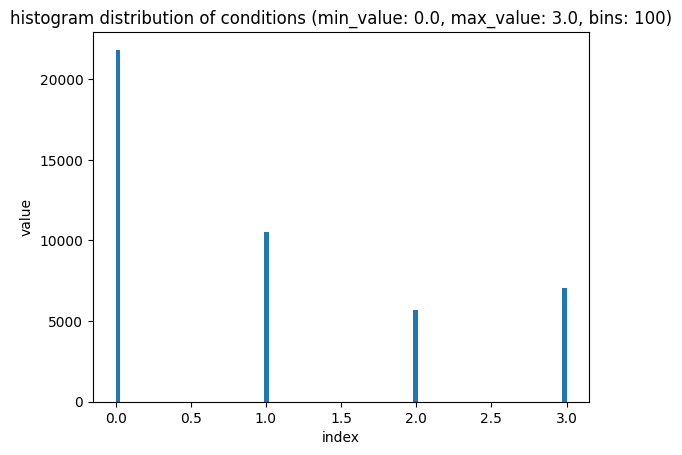

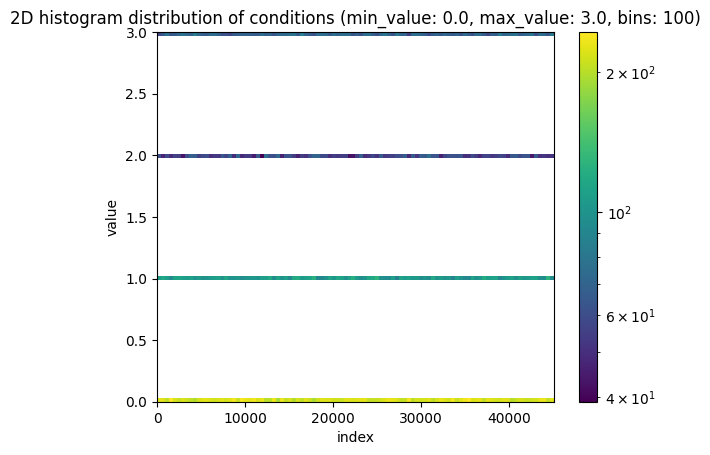

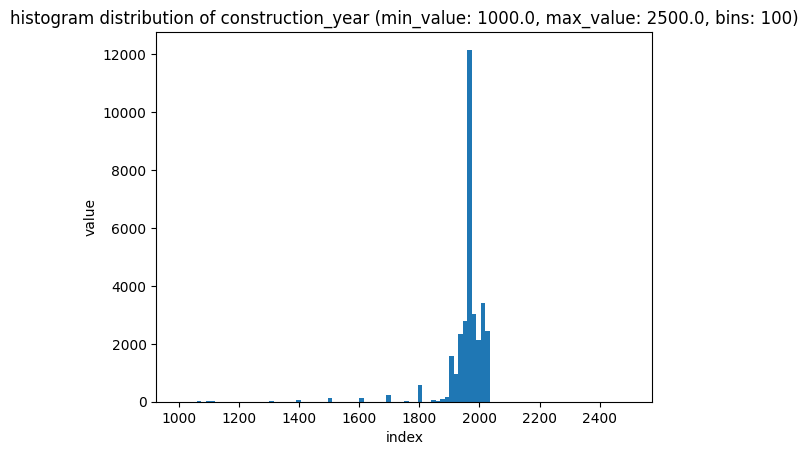

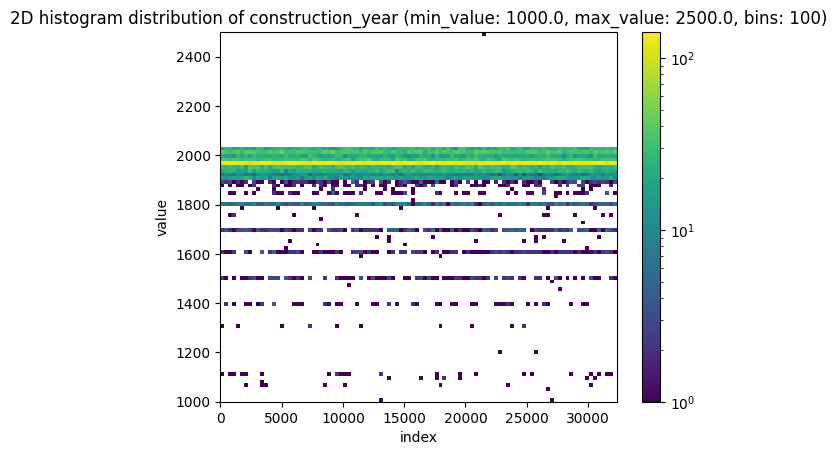

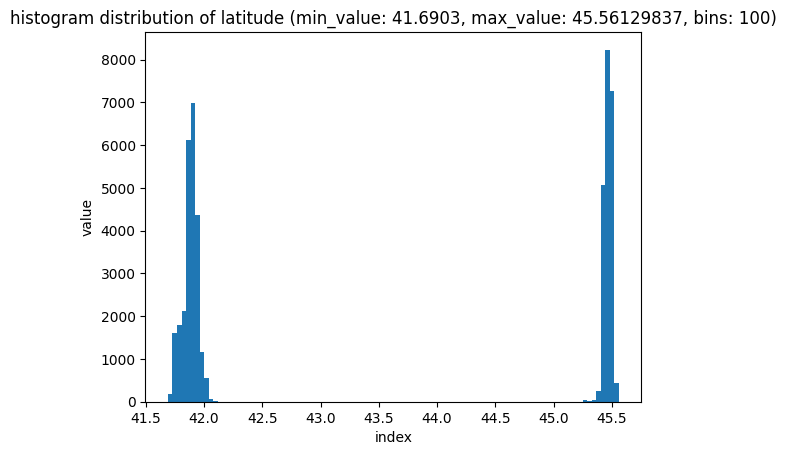

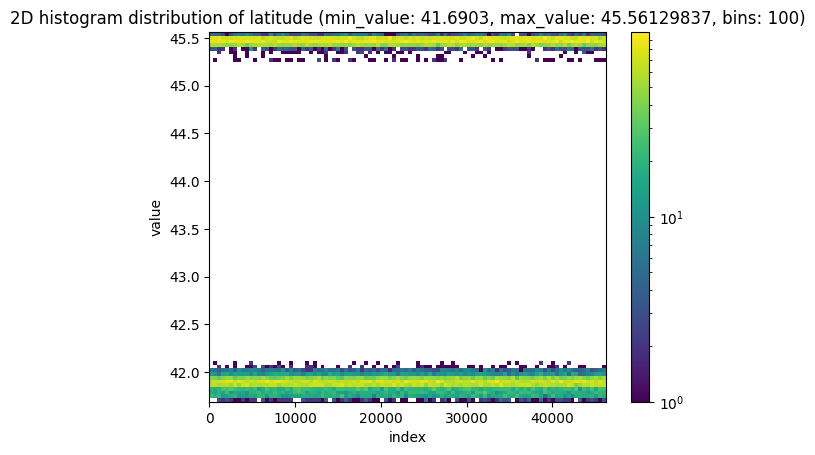

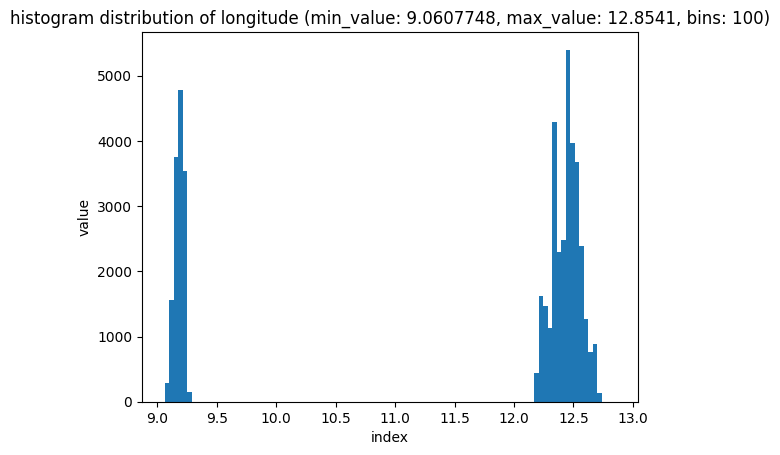

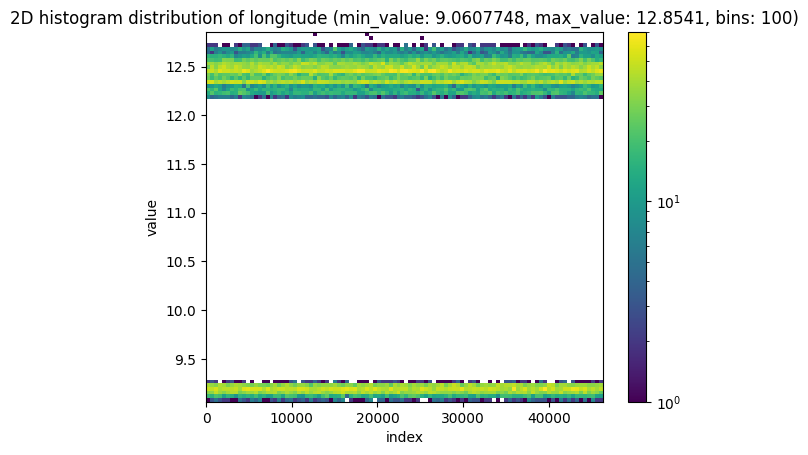

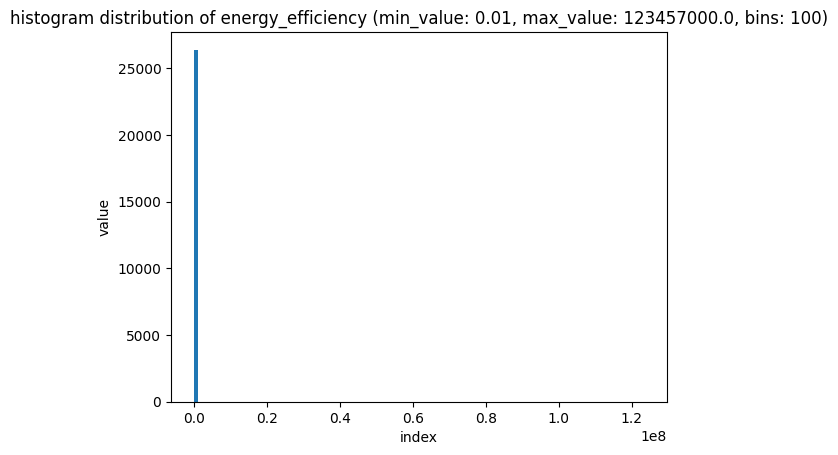

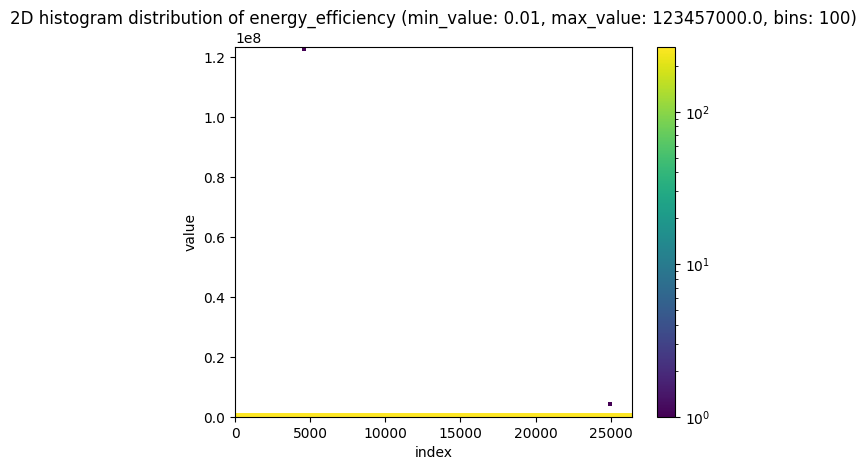

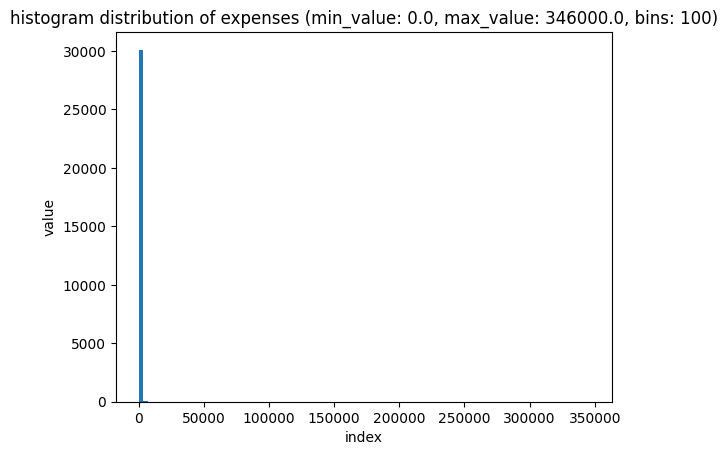

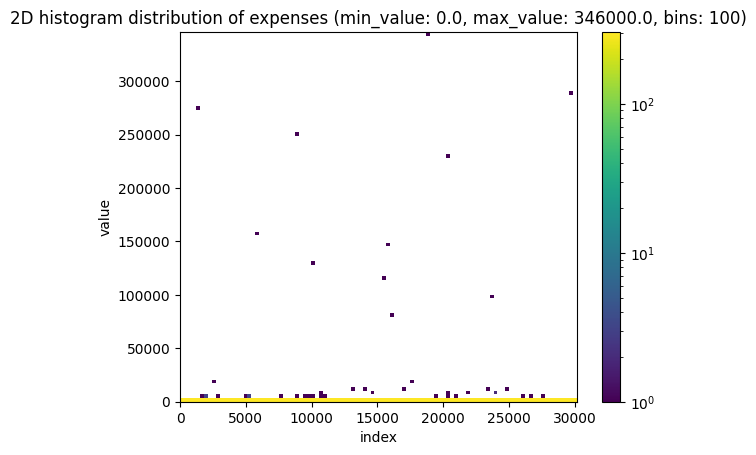

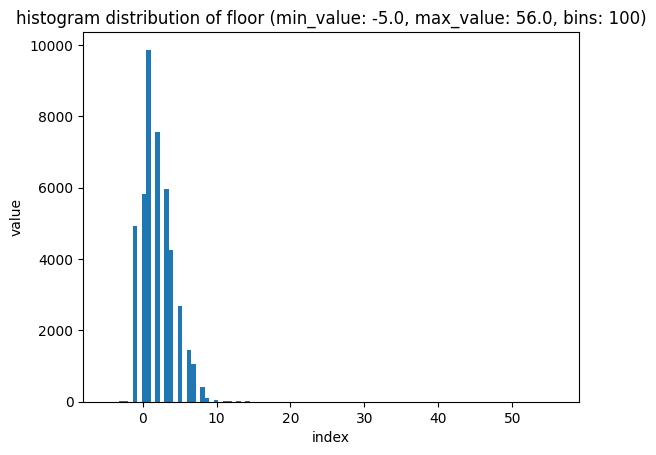

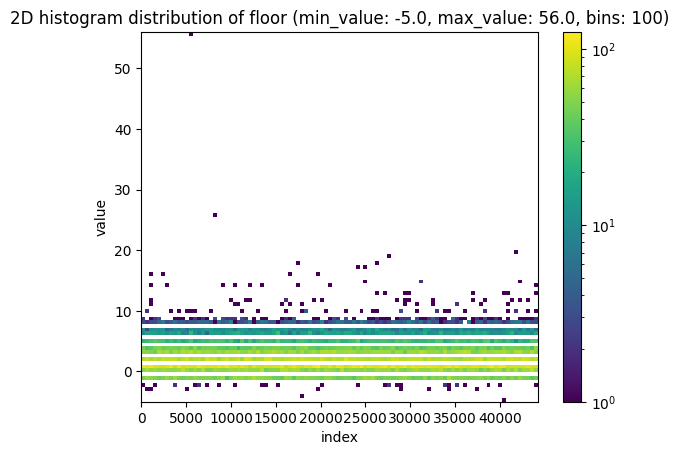

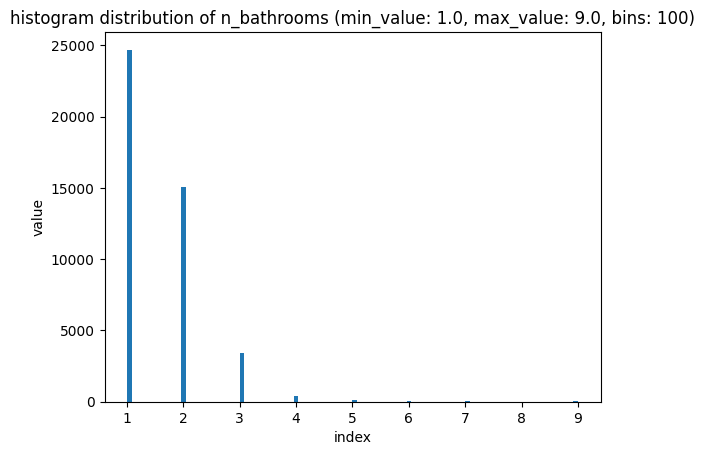

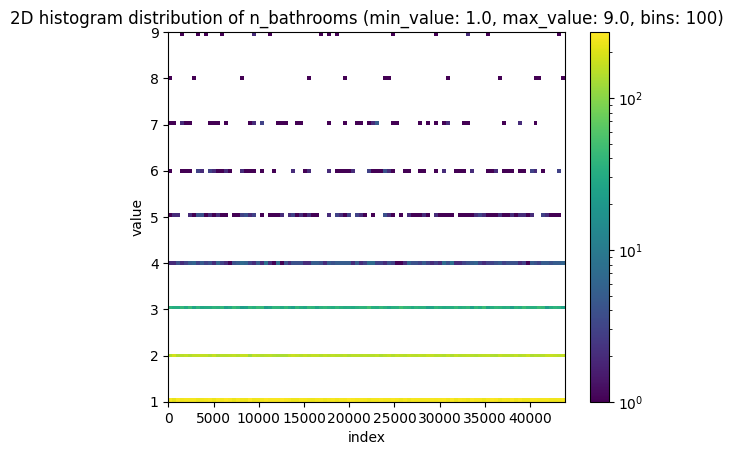

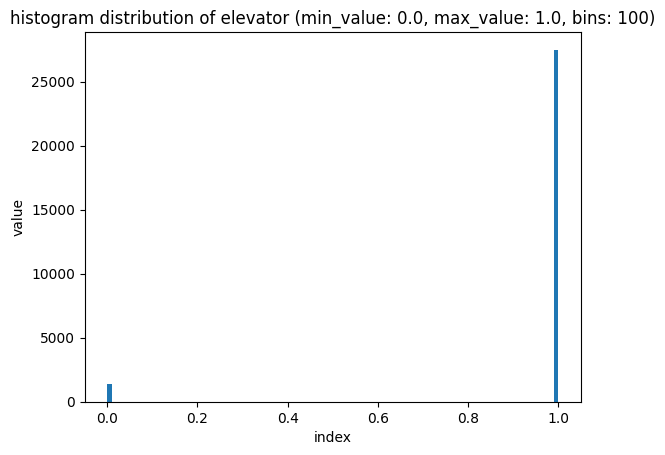

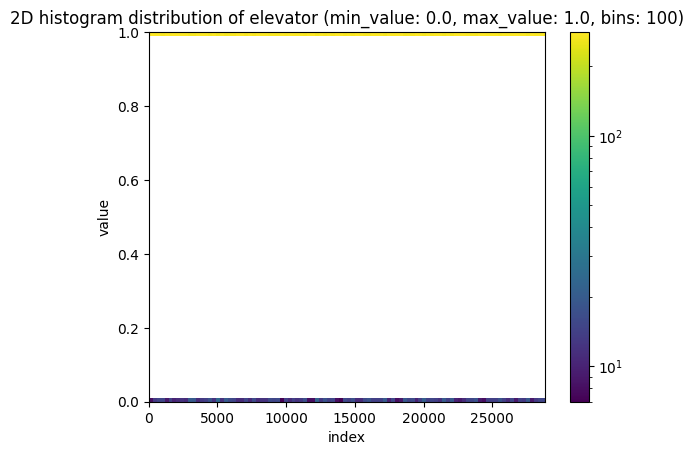

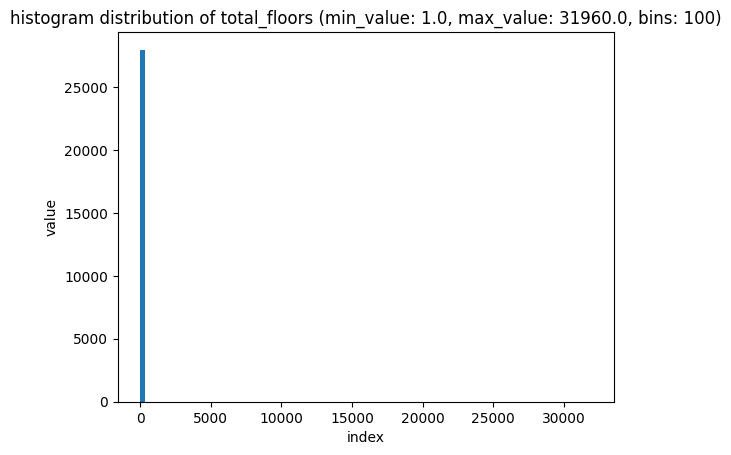

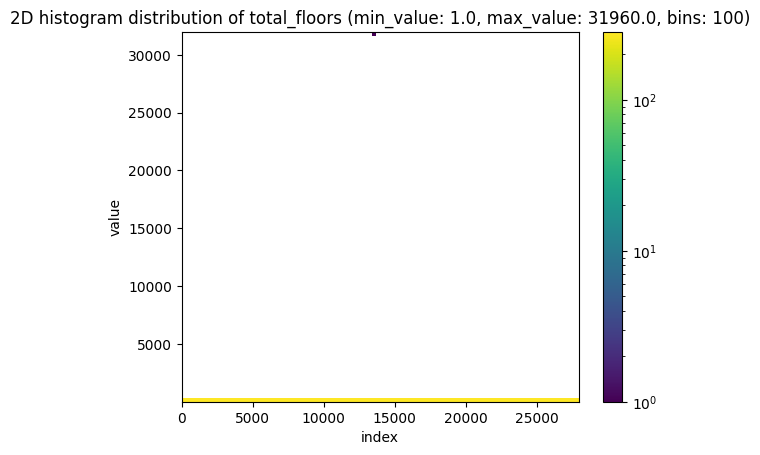

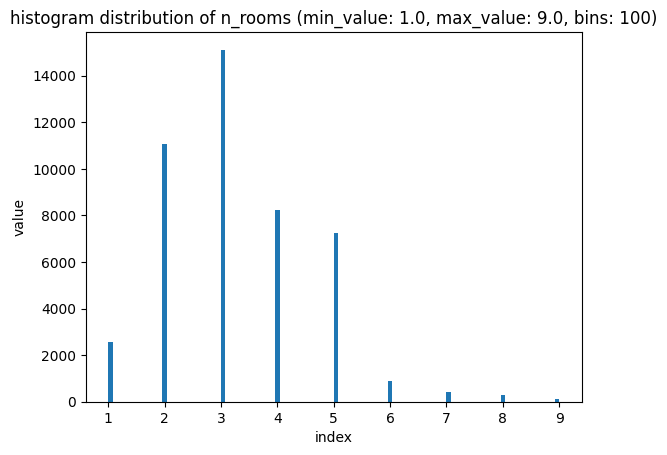

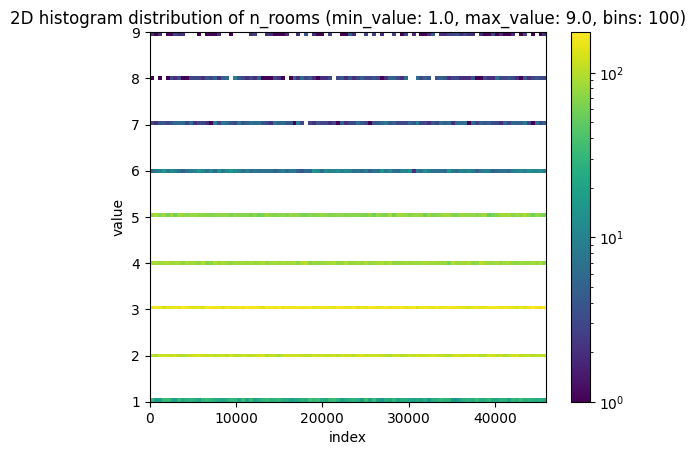

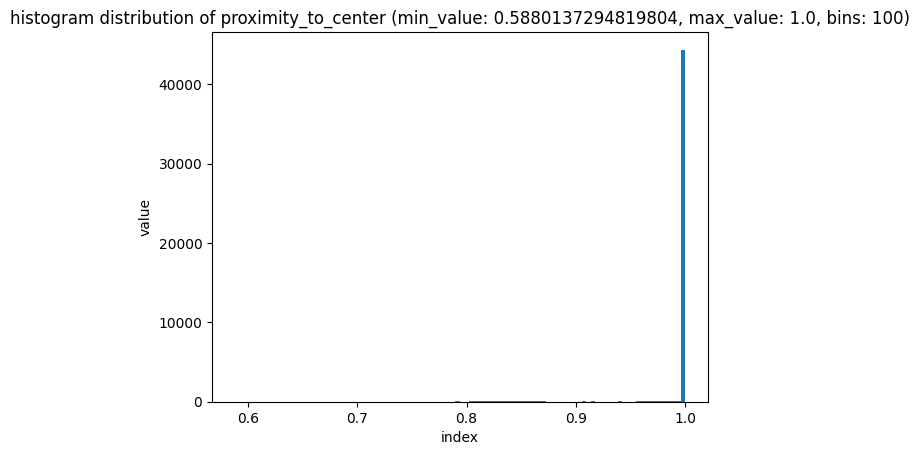

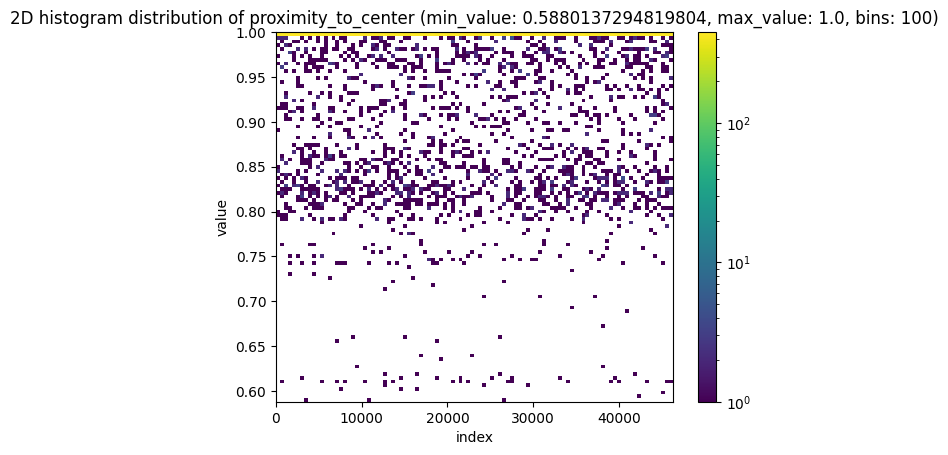

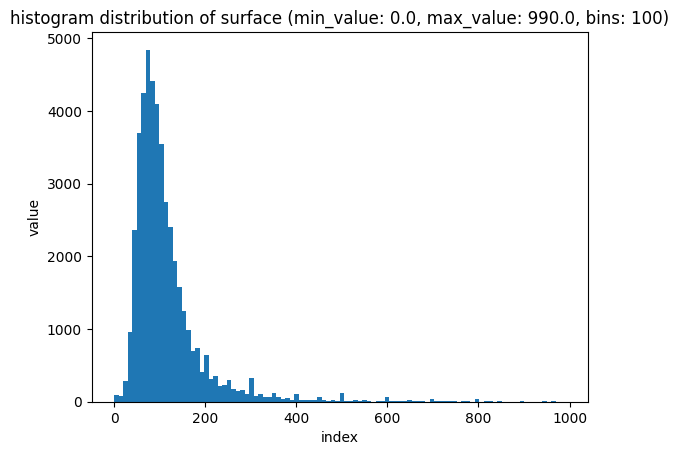

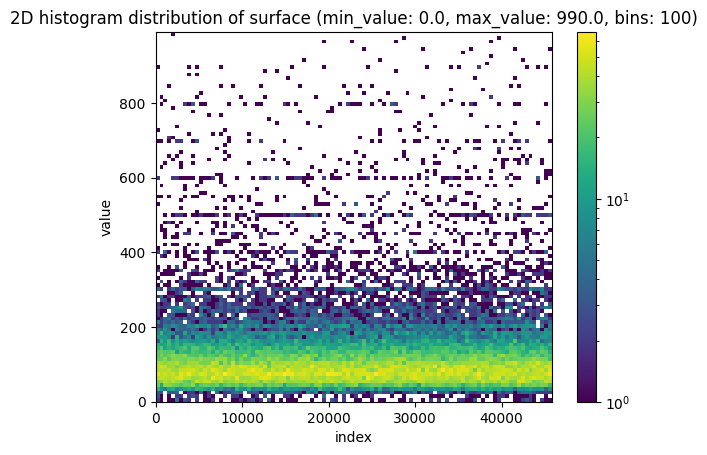

In [20]:
for col in columns_wnan:
    get_hist(train_df, col)

In [21]:
from sklearn.impute import KNNImputer
imputer = KNNImputer()
train_df = pd.DataFrame(imputer.fit_transform(train_df), columns=train_df.columns)

In [22]:
analysis1, analysis2 = NaN_analysis(train_df)

In [23]:
analysis1

column  n_nan  percentage
0                 price      0         0.0
1               balcony      0         0.0
2            conditions      0         0.0
3     construction_year      0         0.0
4              latitude      0         0.0
5             longitude      0         0.0
6     energy_efficiency      0         0.0
7              expenses      0         0.0
8                 floor      0         0.0
9                garden      0         0.0
10          n_bathrooms      0         0.0
11             elevator      0         0.0
12         total_floors      0         0.0
13              n_rooms      0         0.0
14  proximity_to_center      0         0.0
15              surface      0         0.0

In [24]:
analysis2

n_nan  n_rows
0      16       0
1      15       0
2      14       0
3      13       0
4      12       0
5      11       0
6      10       0
7       9       0
8       8       0
9       7       0
10      6       0
11      5       0
12      4       0
13      3       0
14      2       0
15      1       0

In [25]:
train_df

price  balcony  conditions  construction_year   latitude  longitude   
0       60000.0      1.0         0.0             1980.0  41.901300  12.700000  \
1      900000.0      0.0         0.0             1909.0  41.907017  12.481311   
2       33000.0      0.0         0.0             1960.0  41.976500  12.440500   
3      166000.0      0.0         1.0             1982.4  45.484800  12.198200   
4      410000.0      1.0         0.0             1966.2  45.424480  12.328622   
...         ...      ...         ...                ...        ...        ...   
46307  329999.0      1.0         0.0             1929.0  41.923500  12.446100   
46308  599000.0      1.0         2.0             1920.0  41.916743  12.454925   
46309  549000.0      1.0         0.0             1975.2  45.454701   9.242711   
46310  189000.0      1.0         0.0             1965.0  45.445605   9.245942   
46311  355000.0      1.0         1.0             1970.0  41.877000  12.431400   

       energy_efficiency  expenses  floor  garden  n_bathrooms  elevator   
0                175.000      30.0    2.0     0.0          1.0       1.0  \
1                156.730     112.2    3.0     0.0          1.0       1.0   
2                204.200      30.0    4.0     0.0          1.0       0.8   
3                175.000      34.6    1.0     1.0          1.0       1.0   
4                 65.910      84.2    3.0     0.0          2.0       1.0   
...                  ...       ...    ...     ...          ...       ...   
46307            175.000      35.0    3.0     0.0          1.0       0.8   
46308            157.162     170.0    6.0     0.0          2.0       1.0   
46309            141.502     158.4    5.2     0.0          2.0       1.0   
46310            177.600     150.0   -1.0     1.0          1.0       1.0   
46311            175.000     100.0    1.0     0.0          1.0       1.0   

       total_floors  n_rooms  proximity_to_center  surface  
0               3.0      1.0              1.00000     35.0  
1               4.8      3.0              1.00000    131.0  
2               4.0      1.0              1.00000     16.0  
3               1.0      2.0              0.99205    100.0  
4               5.2      3.0              1.00000     90.0  
...             ...      ...                  ...      ...  
46307           4.0      3.0              1.00000     88.0  
46308           4.6      5.0              1.00000    189.0  
46309           6.6      3.0              1.00000    140.0  
46310           4.8      3.0              1.00000     70.0  
46311           5.0      4.0              1.00000    101.0  

[46312 rows x 16 columns]

# 2. Dataset analysis

- plottare le distribuzioni
- rimuovere gli outliers (questo solo sul train set)

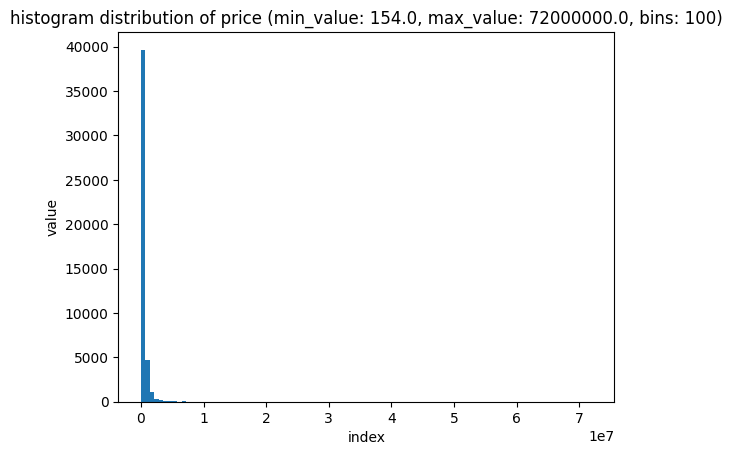

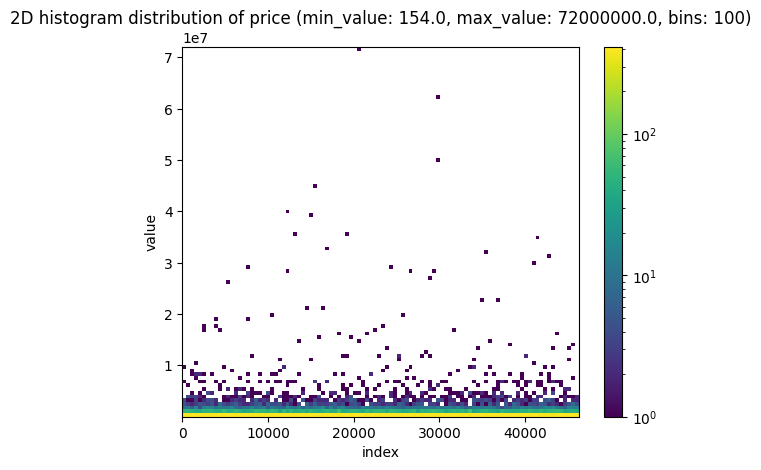

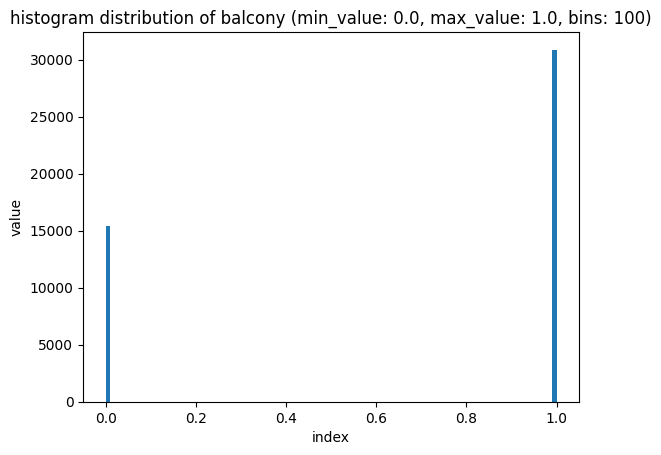

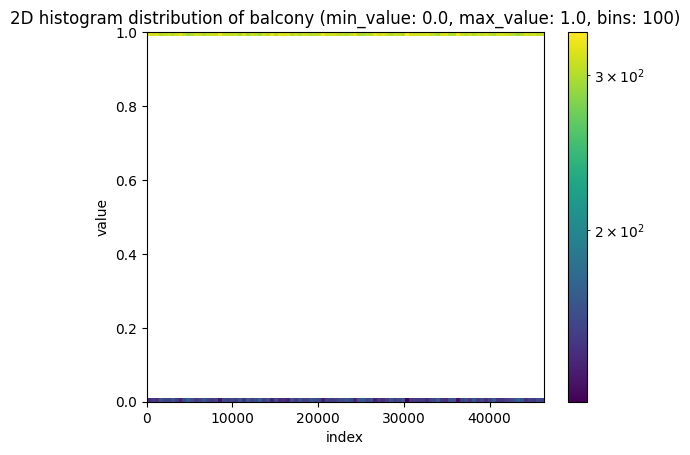

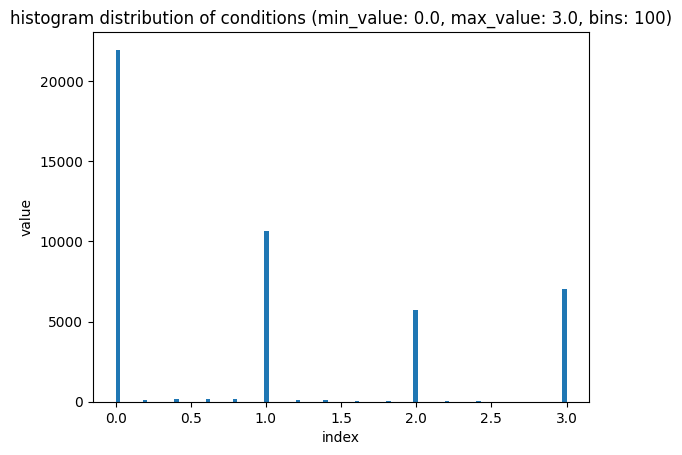

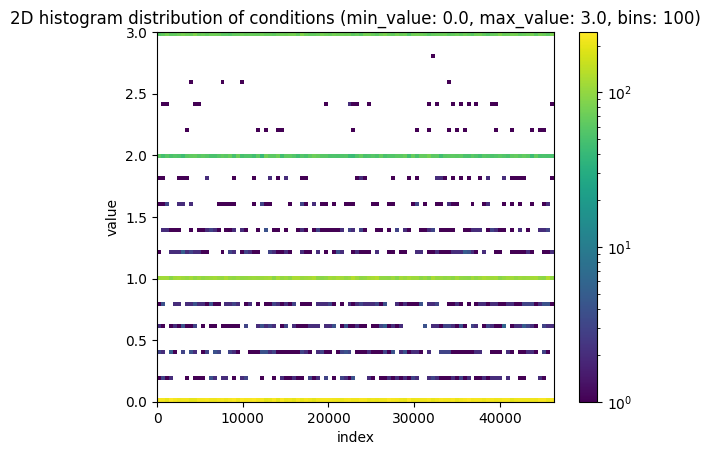

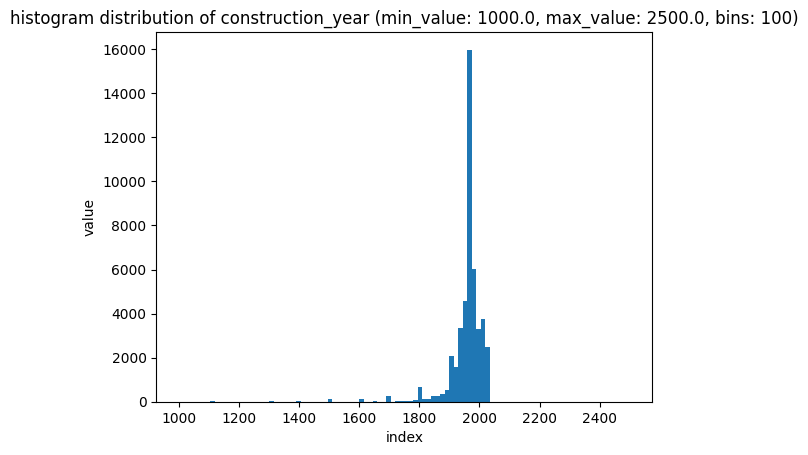

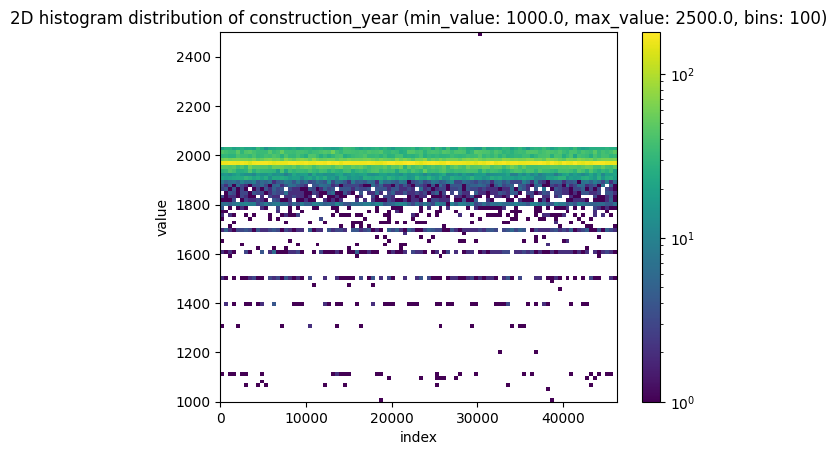

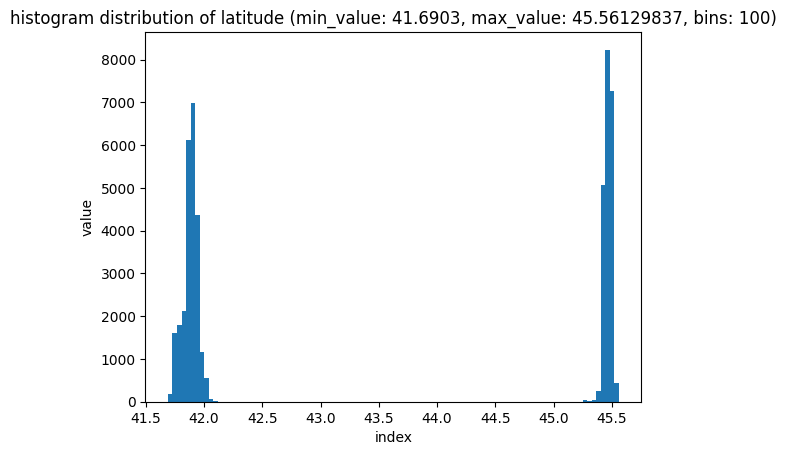

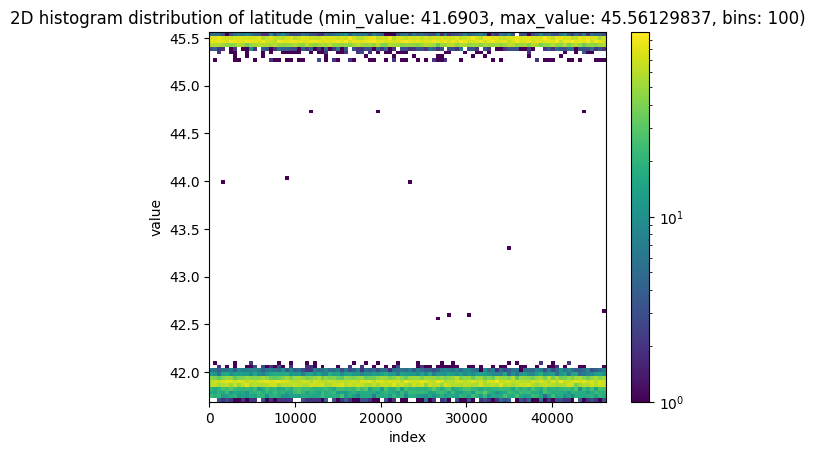

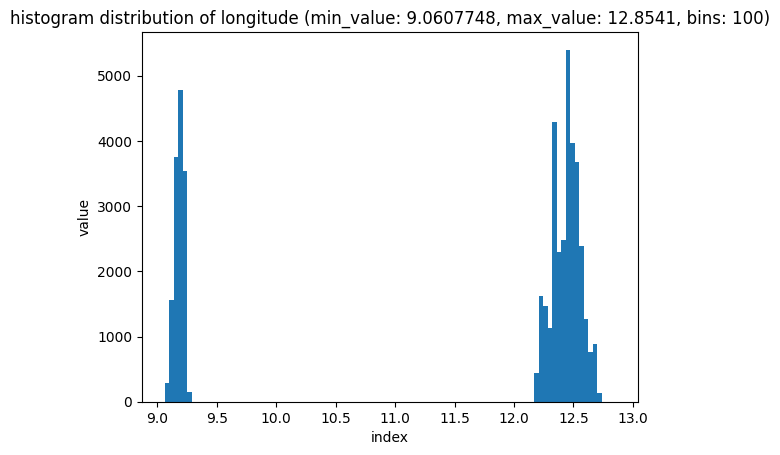

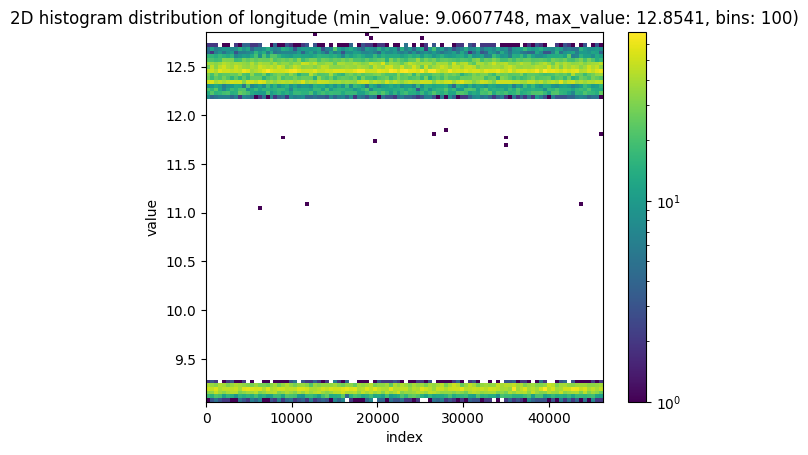

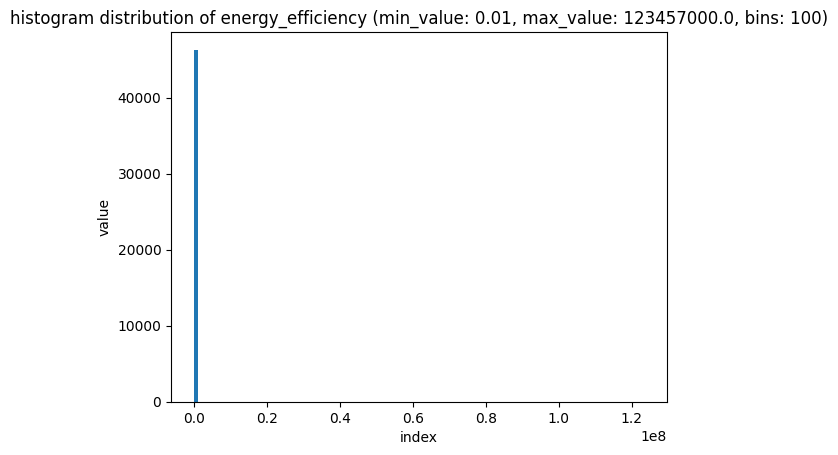

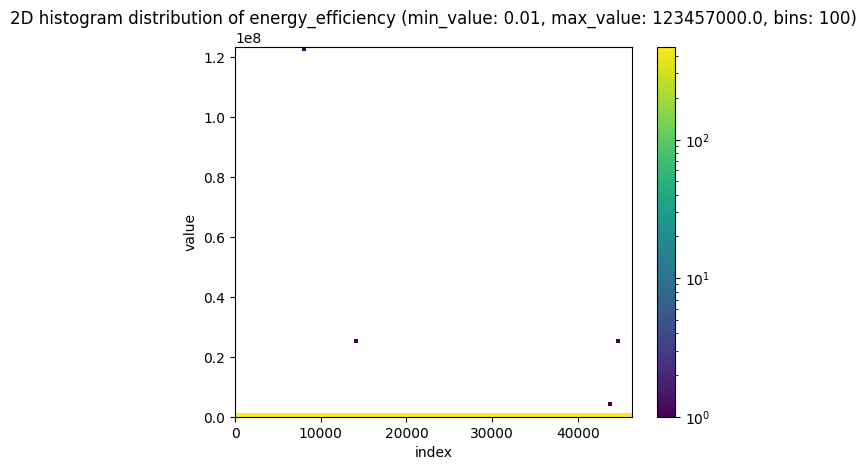

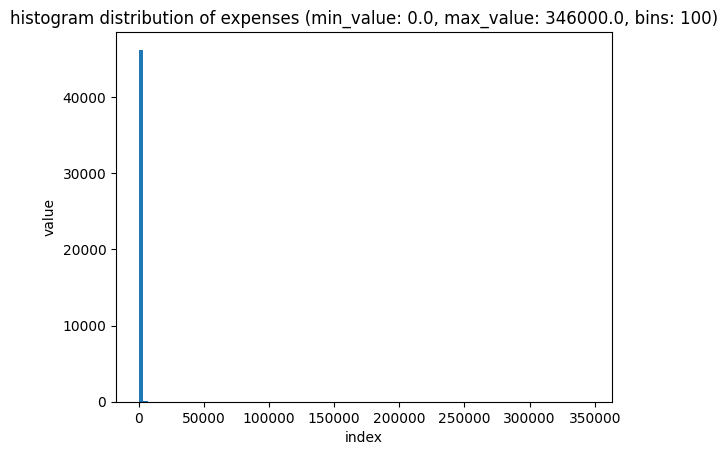

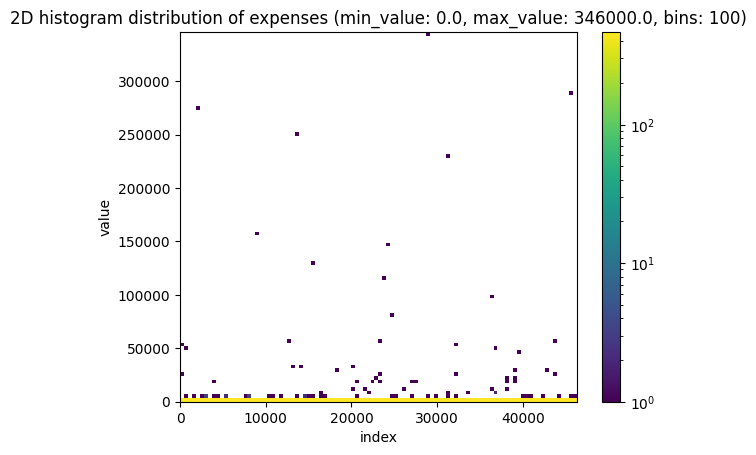

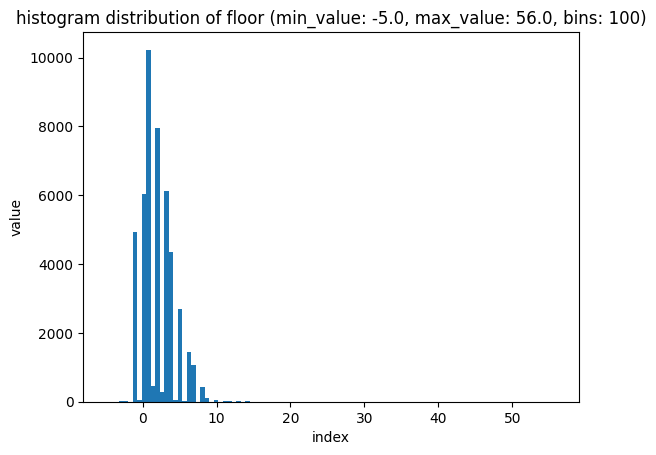

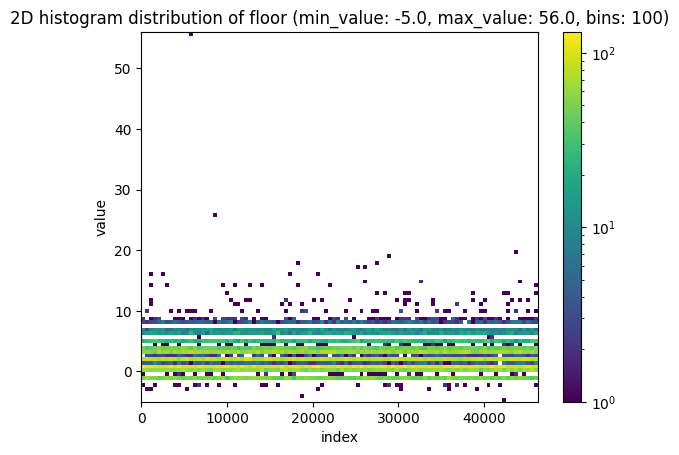

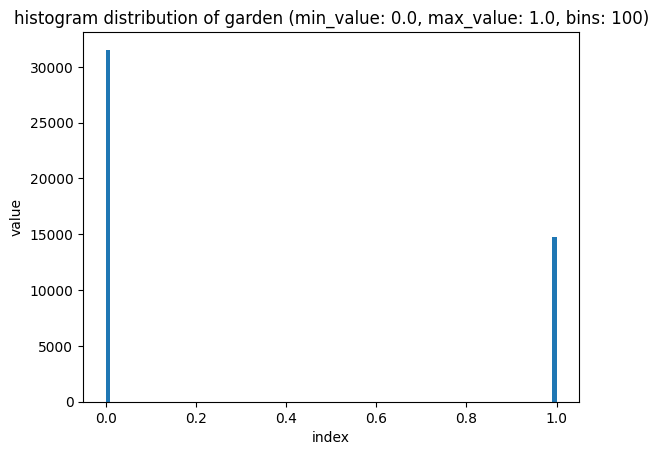

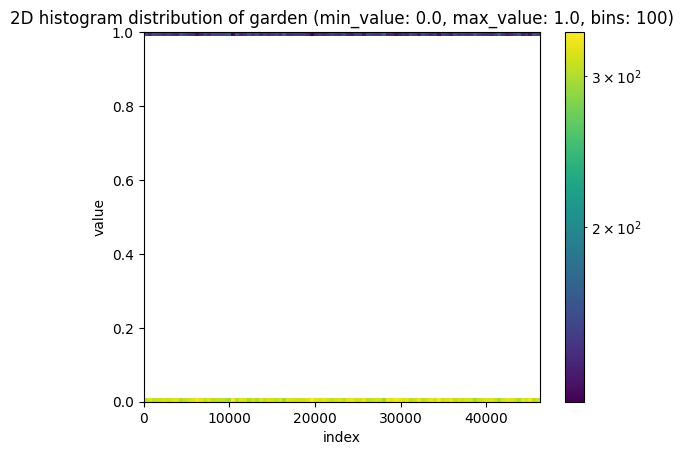

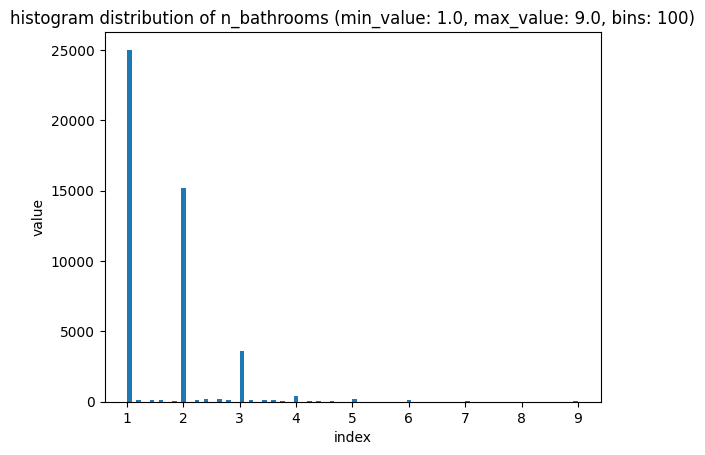

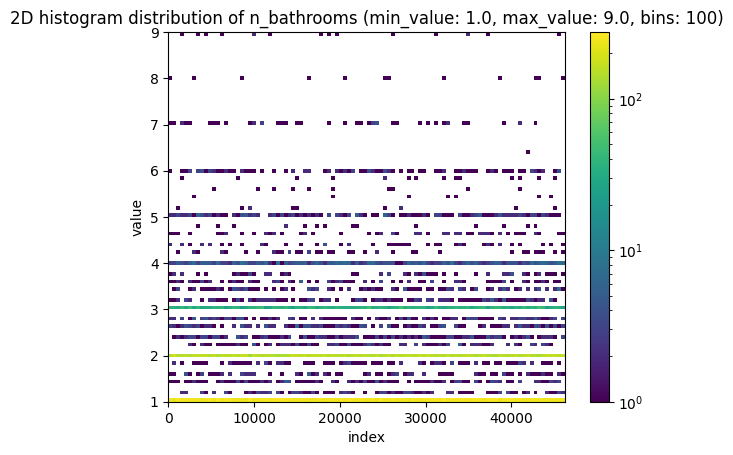

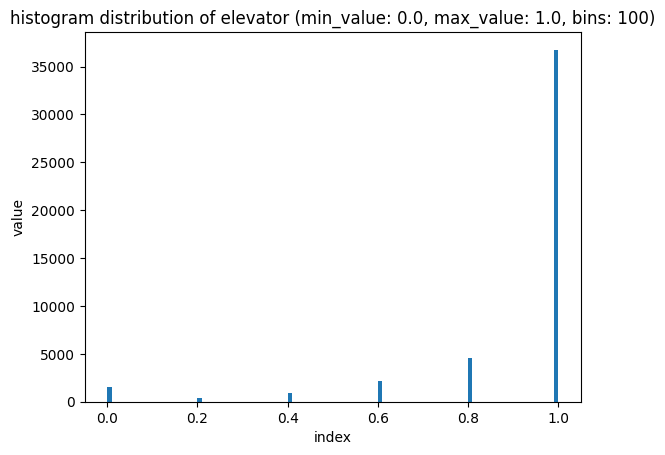

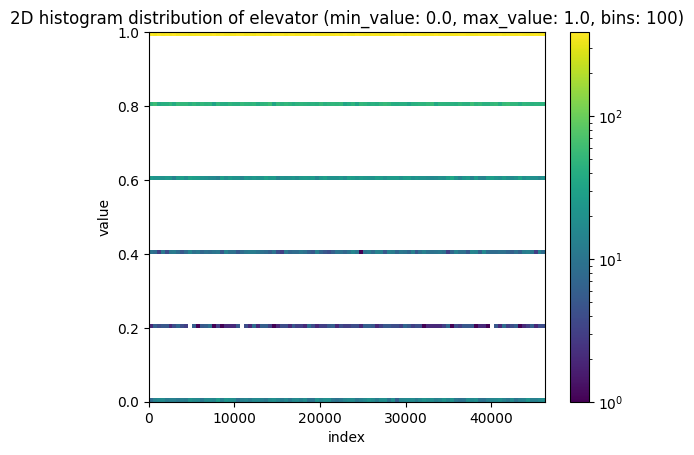

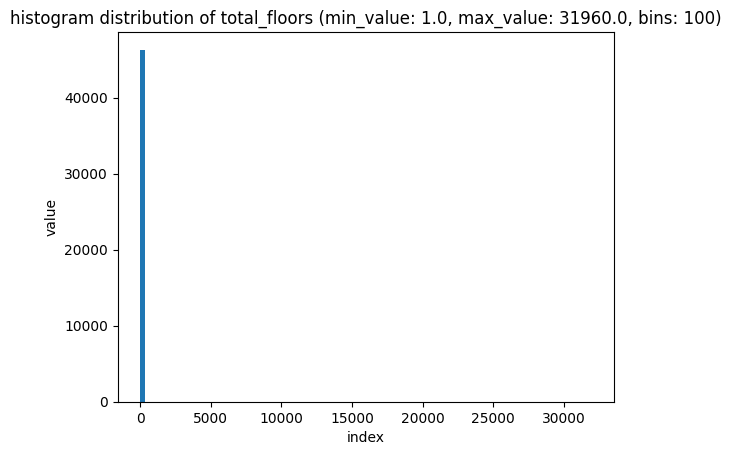

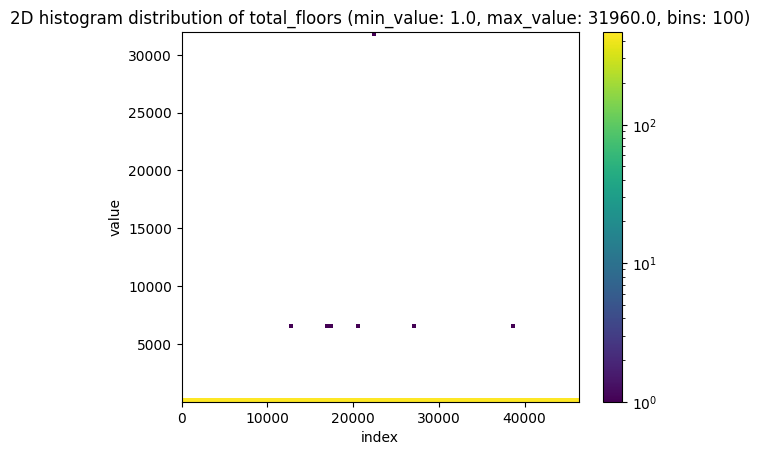

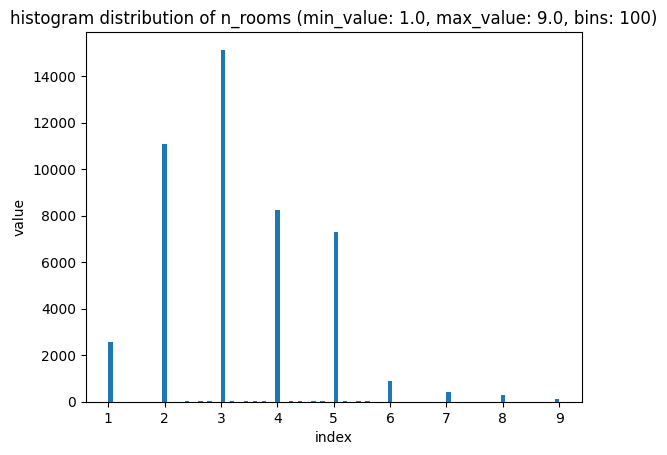

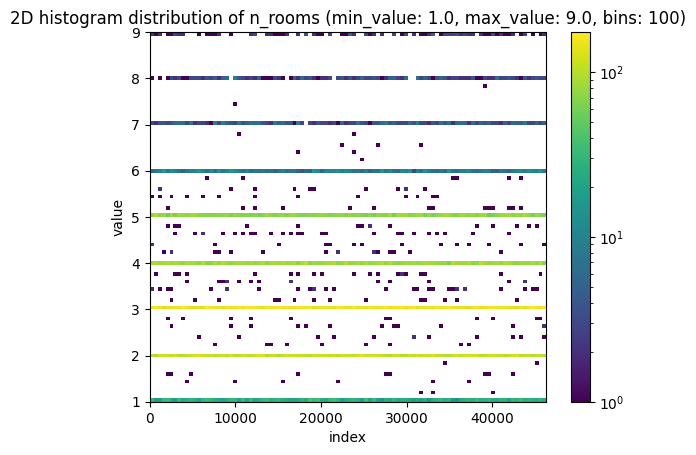

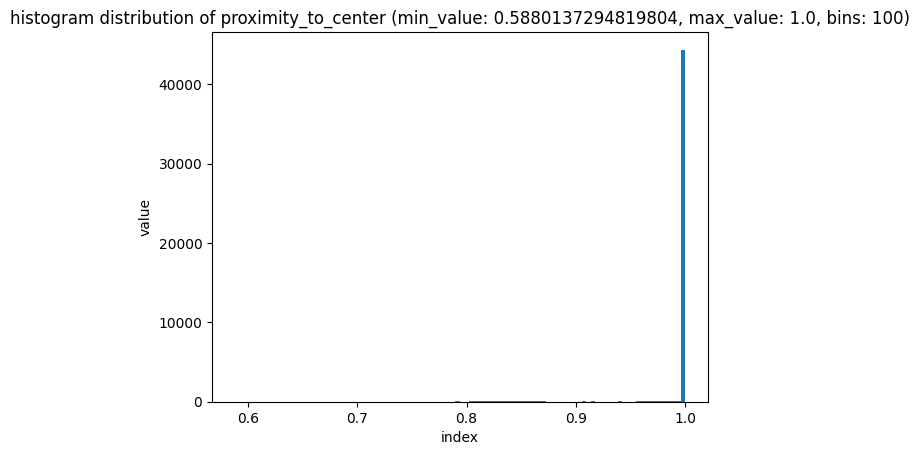

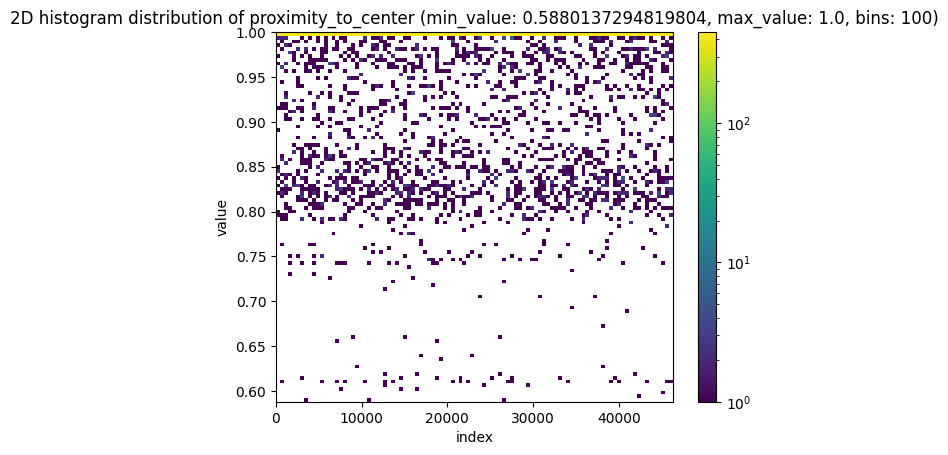

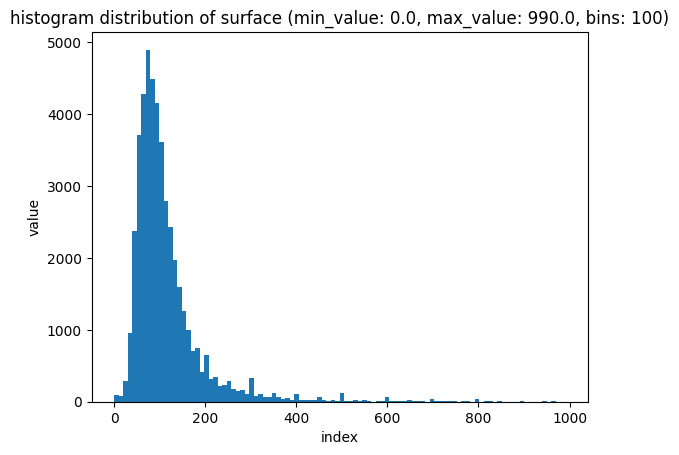

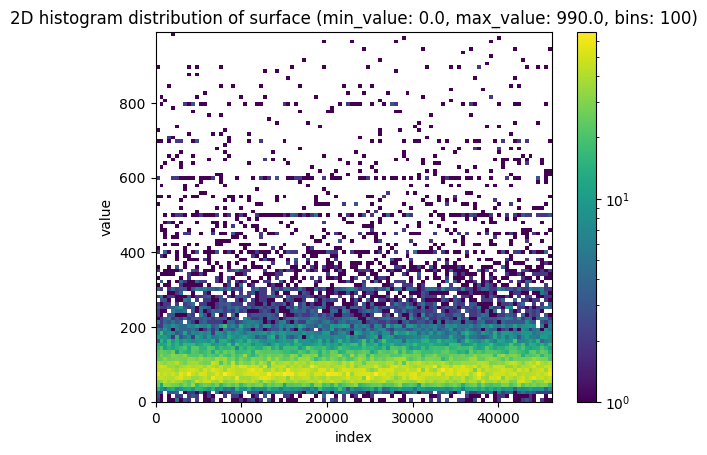

In [26]:
for col in train_df.columns:
    get_hist(train_df, col)

In [27]:
def boxplot(df, feature):
    plt.boxplot(df.loc[:, feature], )
    plt.title('boxplot of {}'.format(feature))
    plt.ylabel('value')
    plt.show()
    plt.close()
    return

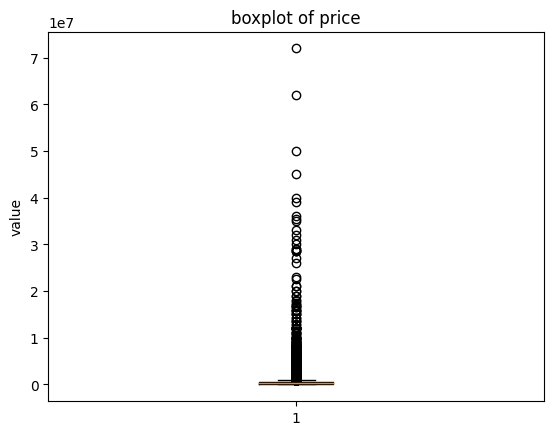

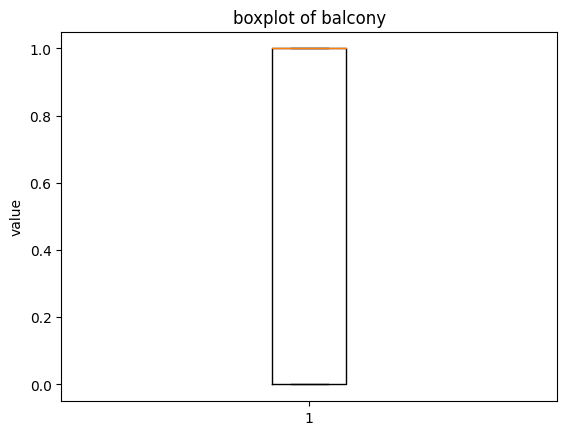

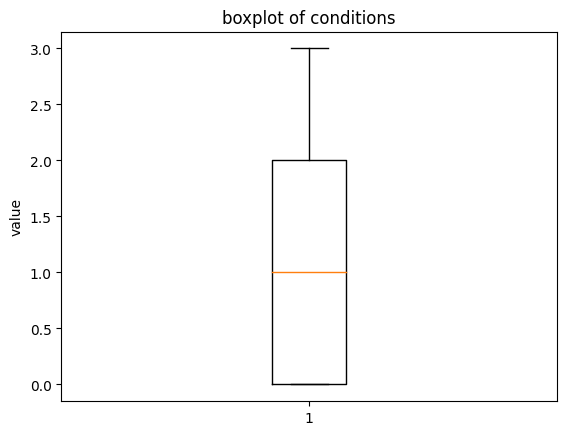

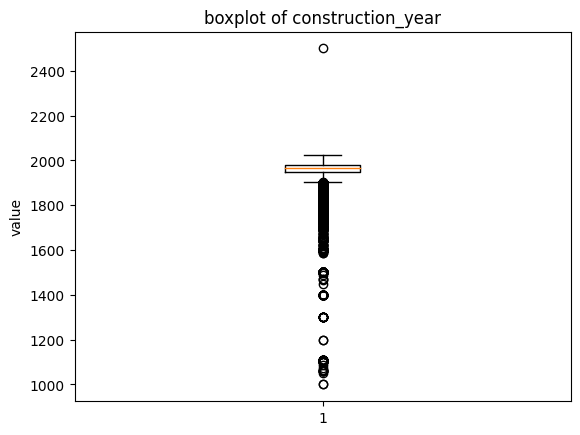

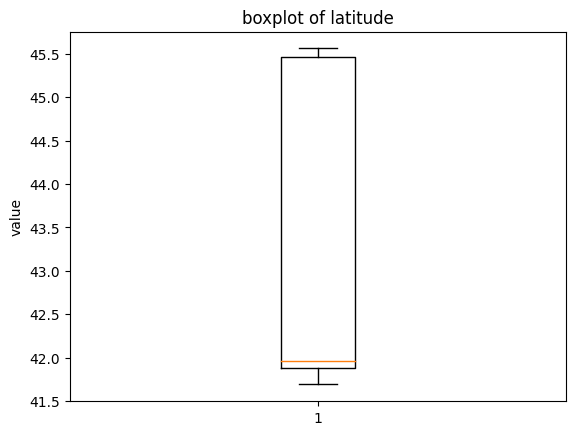

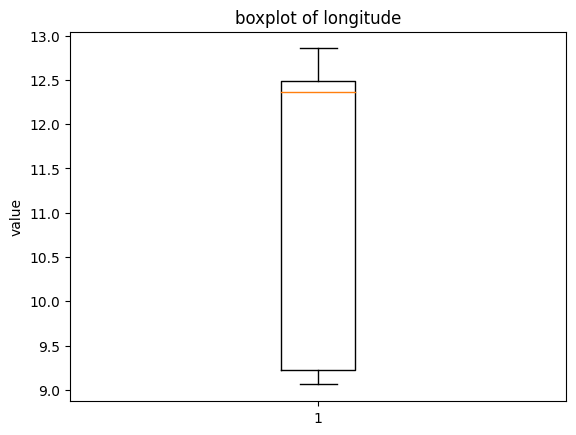

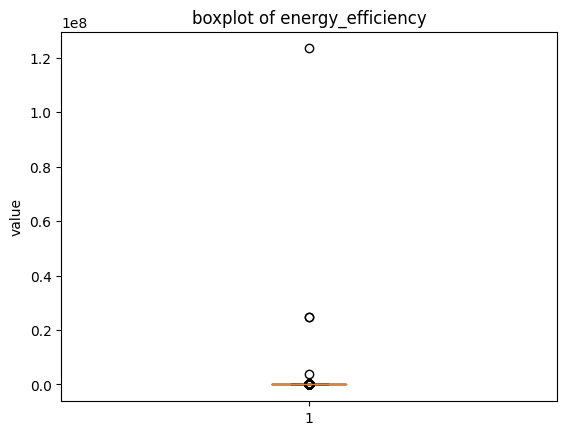

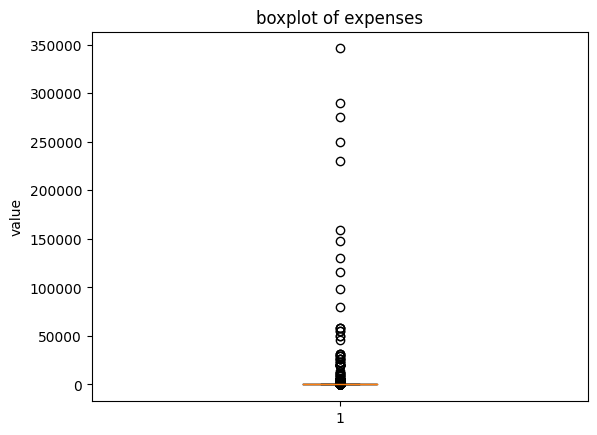

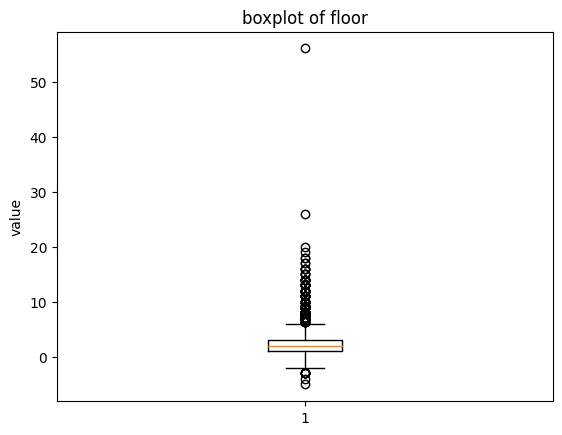

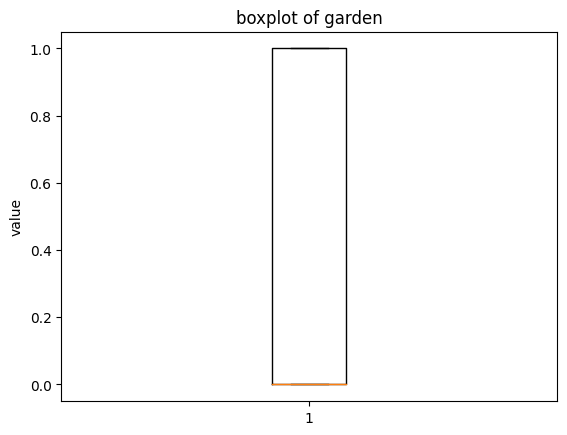

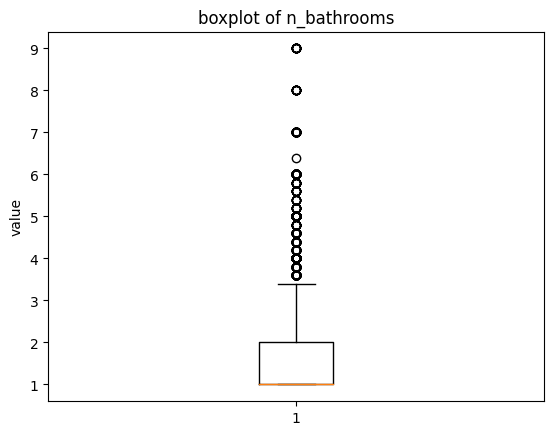

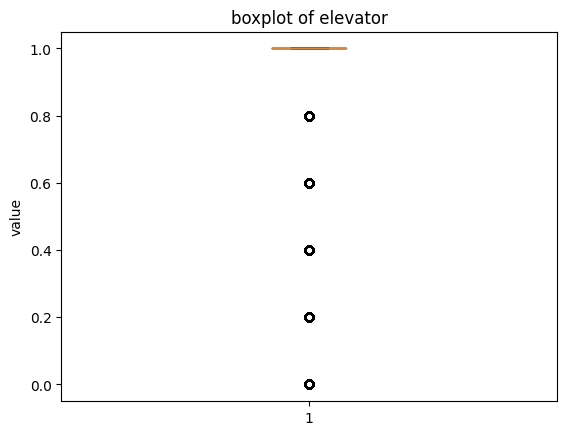

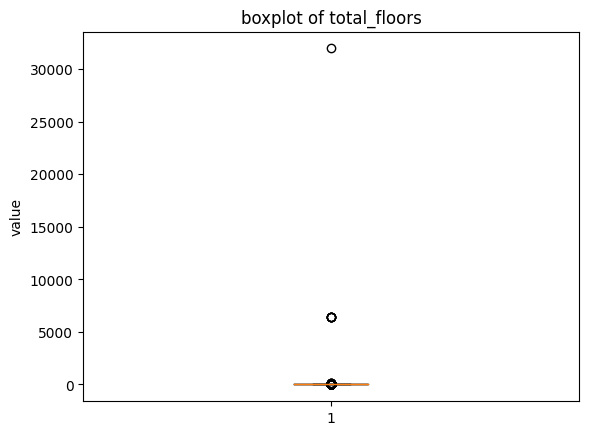

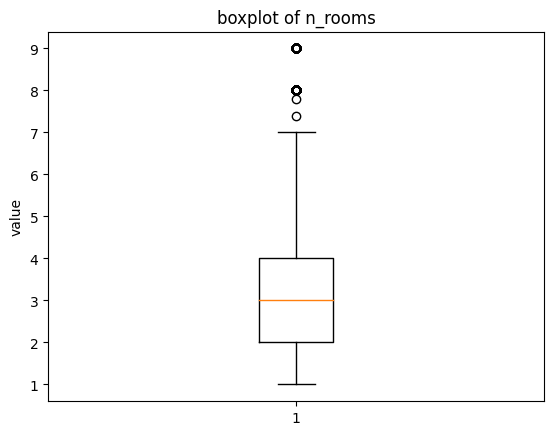

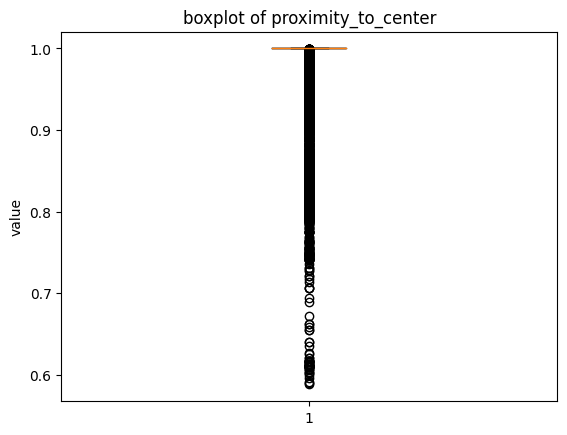

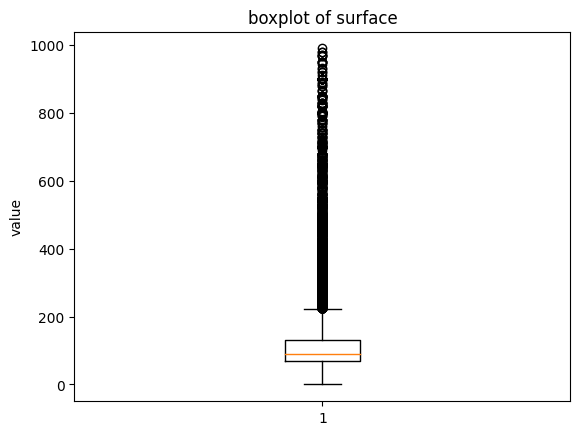

In [28]:
for col in train_df.columns:
    boxplot(train_df, col)

In [29]:
original_shape = train_df.shape[0]
z_scores = zscore(train_df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 5).all(axis=1)

In [30]:
train_df = train_df[filtered_entries]
new_shape = train_df.shape[0]

In [31]:
print('original shape: {}'.format(original_shape))
print('new shape: {}'.format(new_shape))
print('percentage of rows removed: {}%'.format(((original_shape-new_shape)*100)/original_shape))

original shape: 46312
new shape: 44460
percentage of rows removed: 3.9989635515633095%


In [32]:
for col in train_df.columns:
    z_scores = zscore(train_df[col])
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 5)
    tmp_df = train_df[col][filtered_entries]
    lower, upper = tmp_df.min(), tmp_df.max()
    train_df[col] = train_df[col].apply(lambda x: lower if x < lower else upper if x > upper else x)

/tmp/ipykernel_37914/2668509341.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[col] = train_df[col].apply(lambda x: lower if x < lower else upper if x > upper else x)
/tmp/ipykernel_37914/2668509341.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[col] = train_df[col].apply(lambda x: lower if x < lower else upper if x > upper else x)
/tmp/ipykernel_37914/2668509341.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

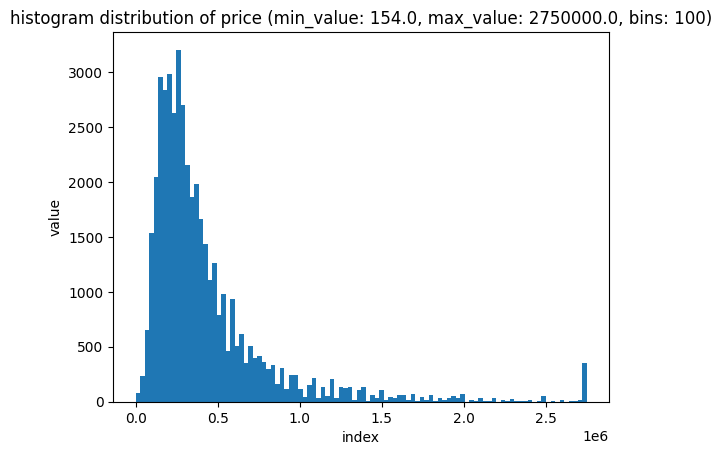

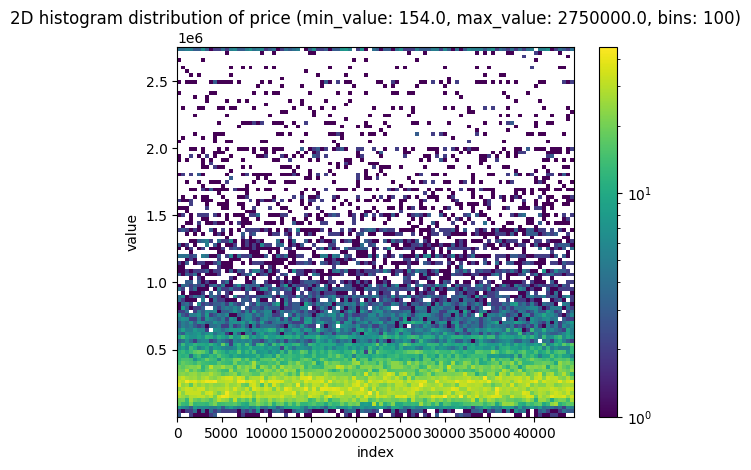

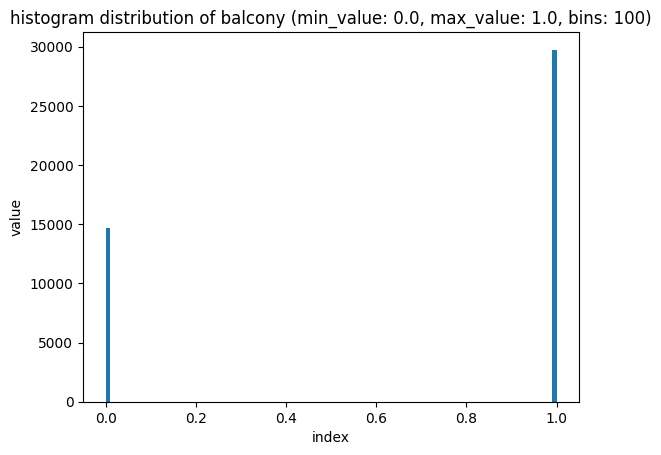

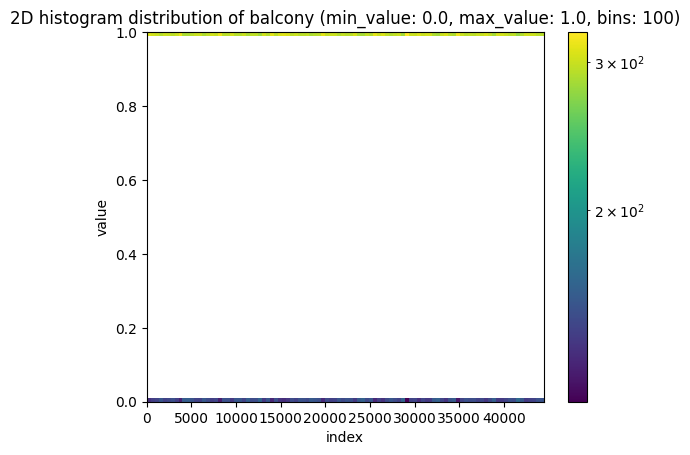

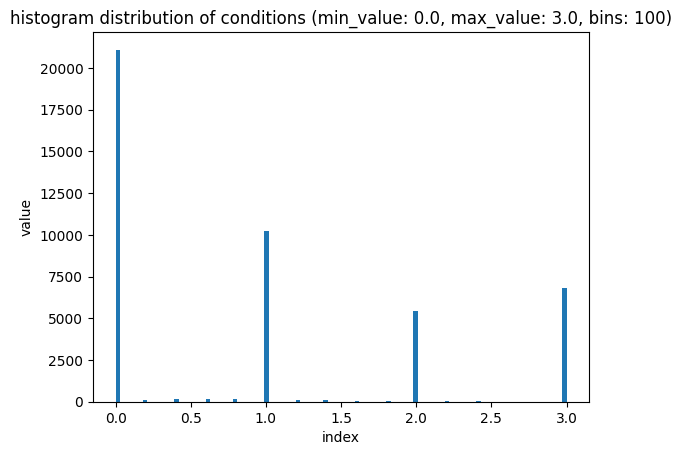

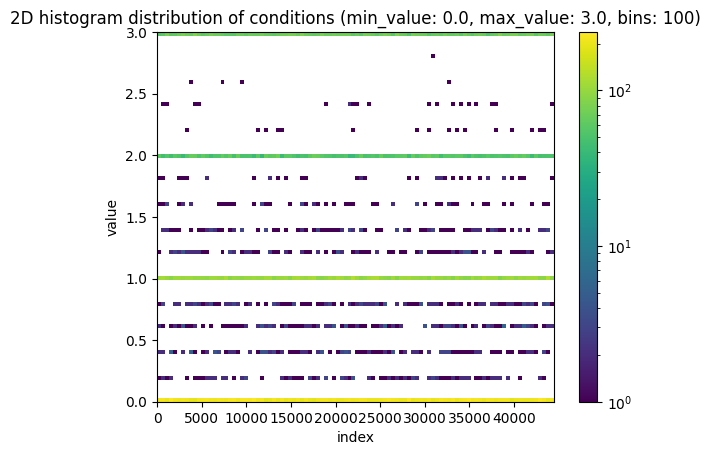

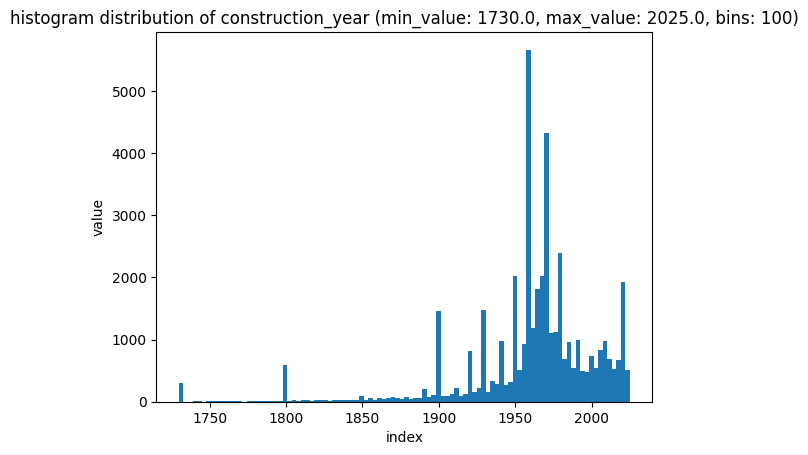

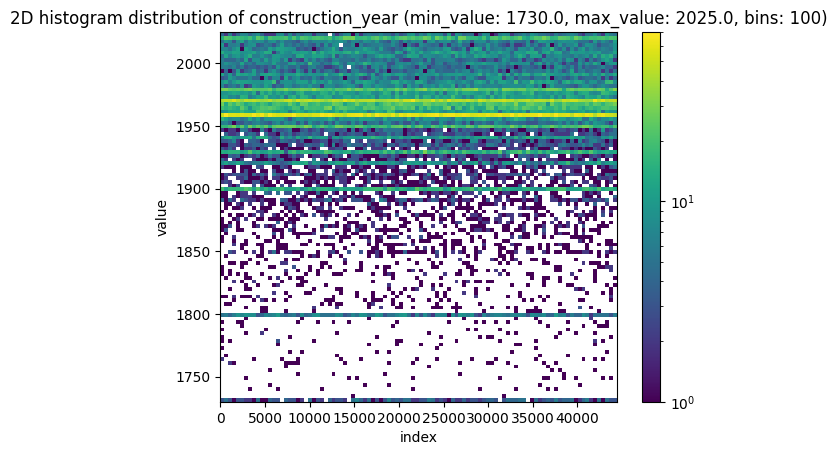

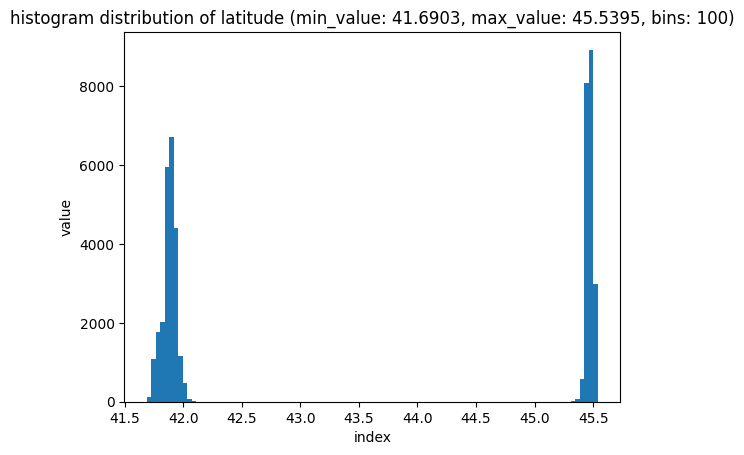

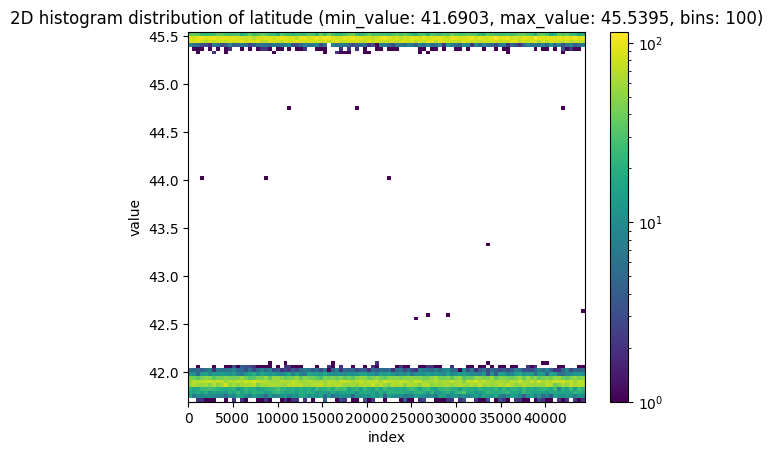

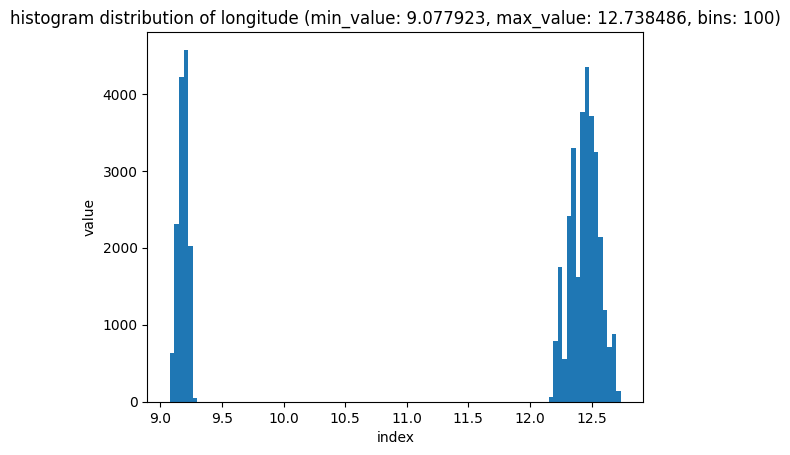

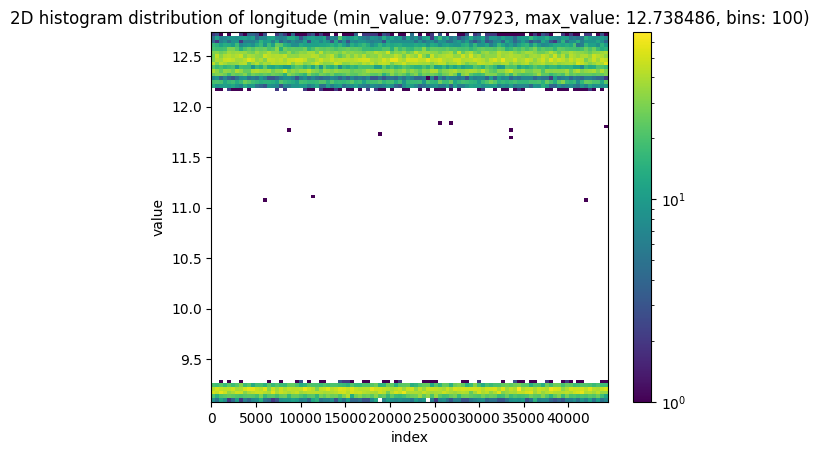

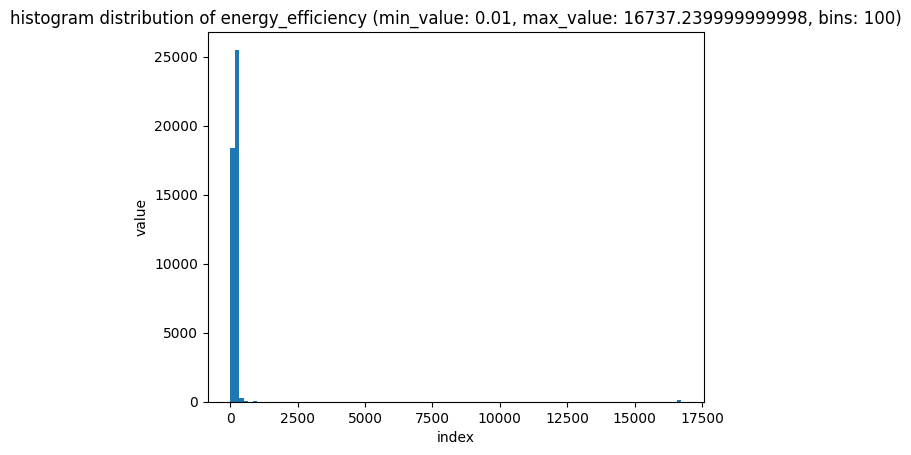

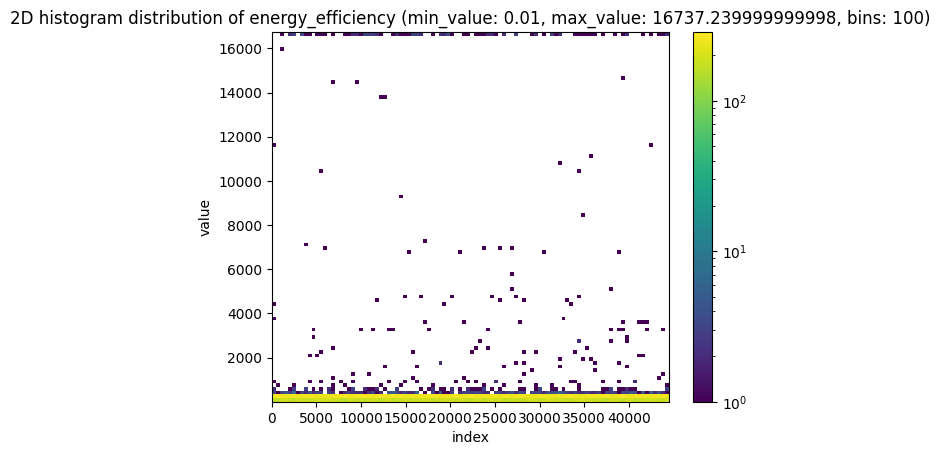

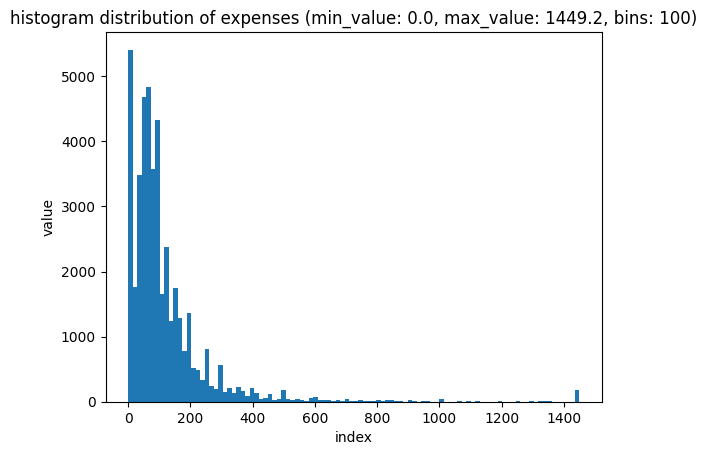

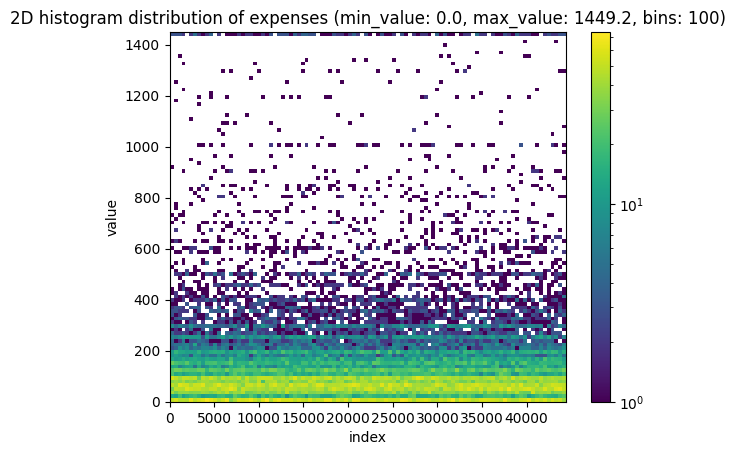

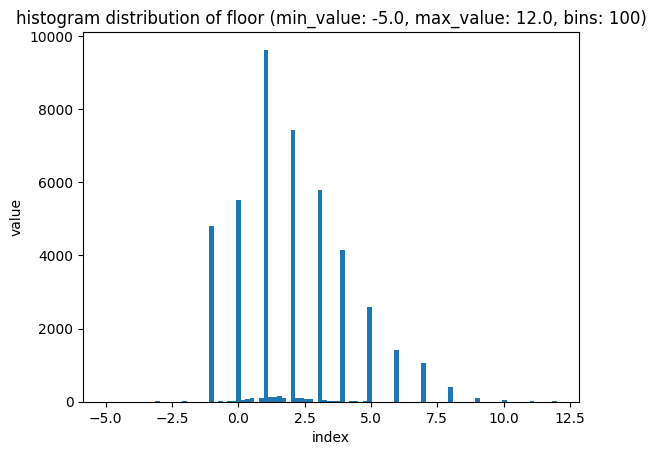

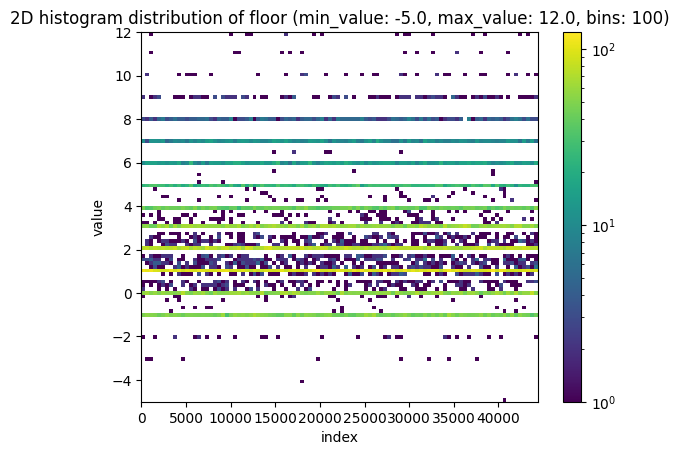

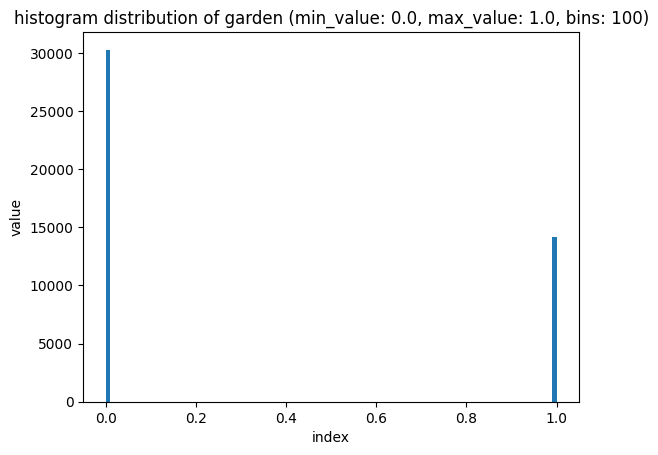

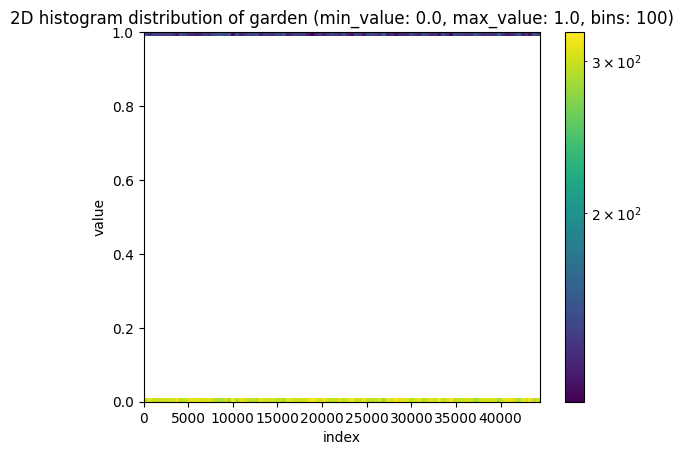

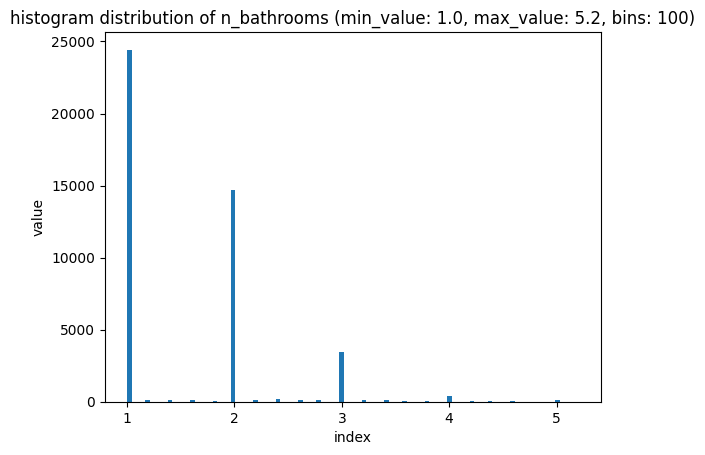

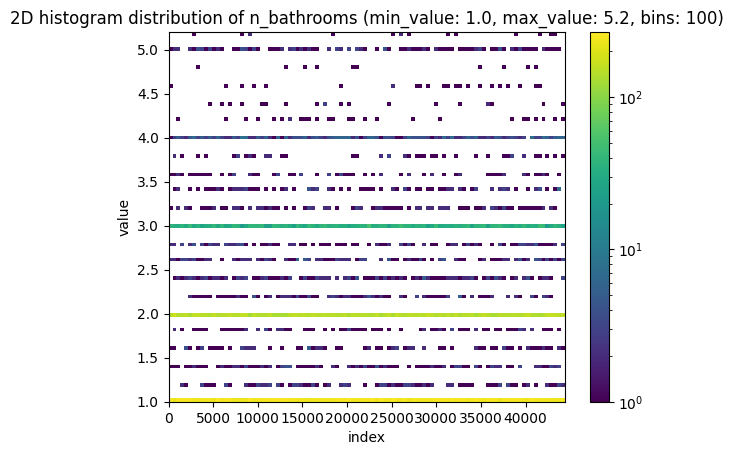

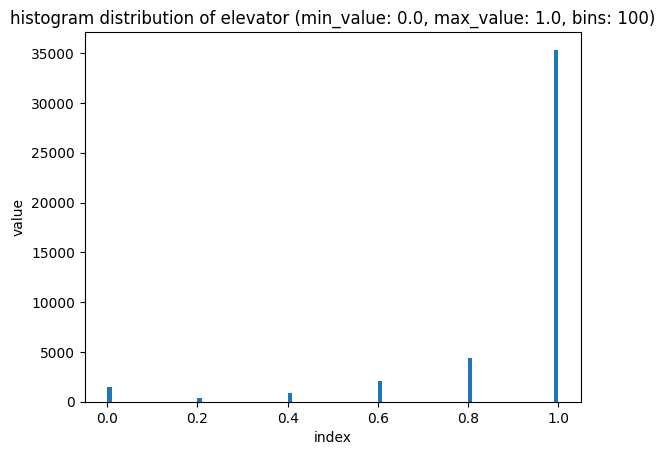

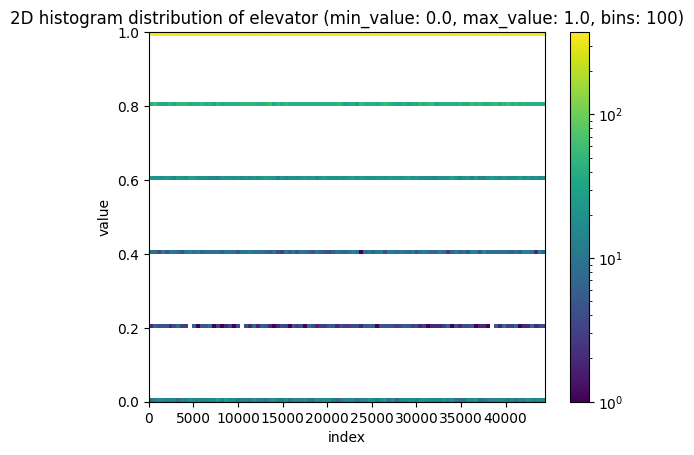

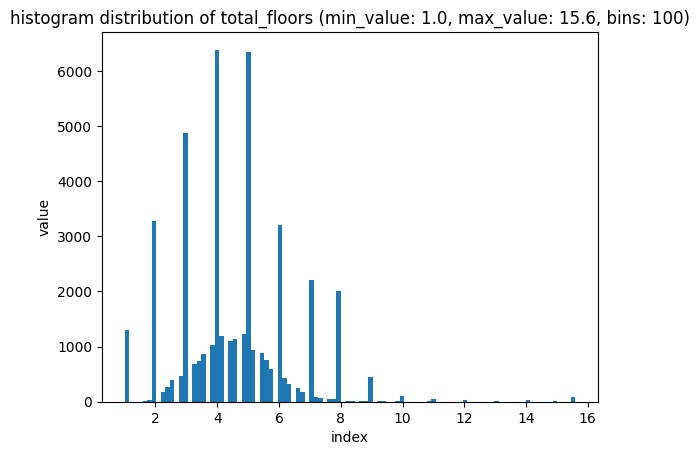

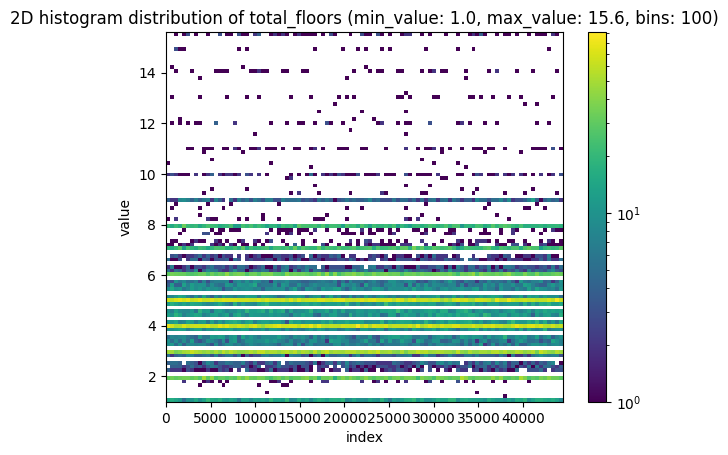

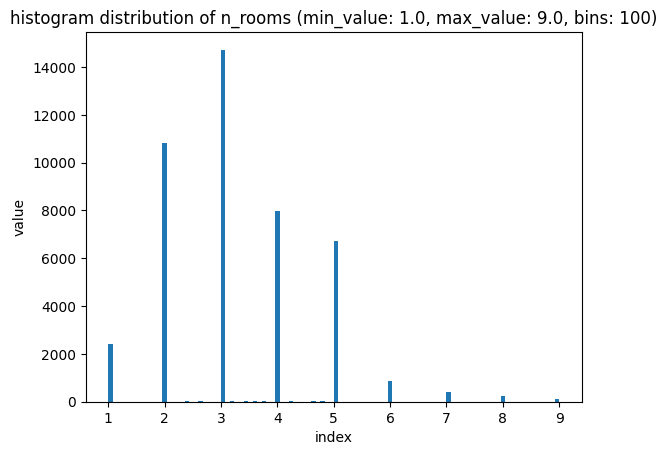

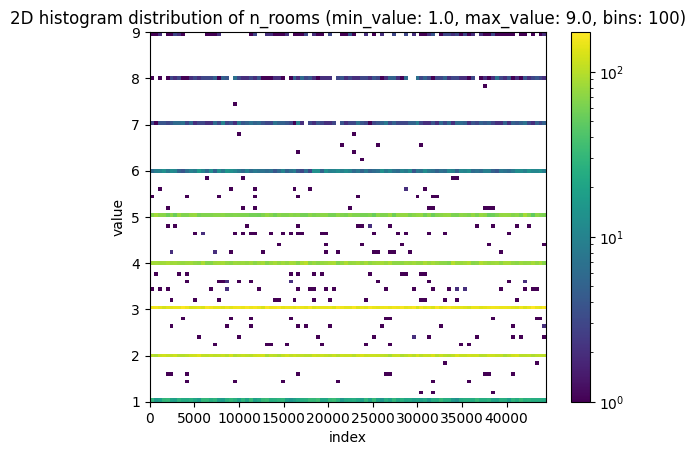

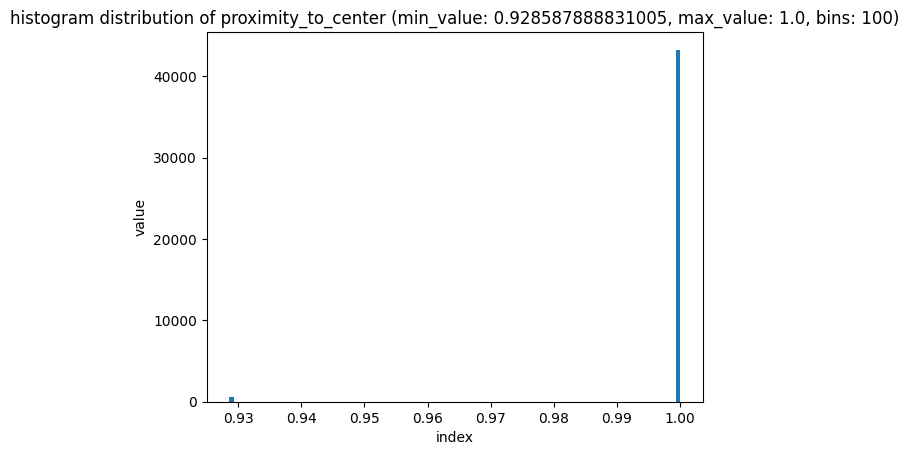

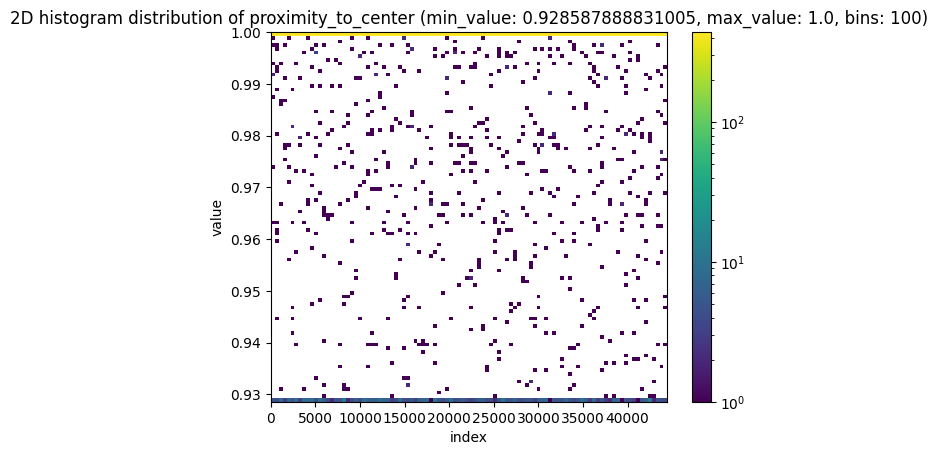

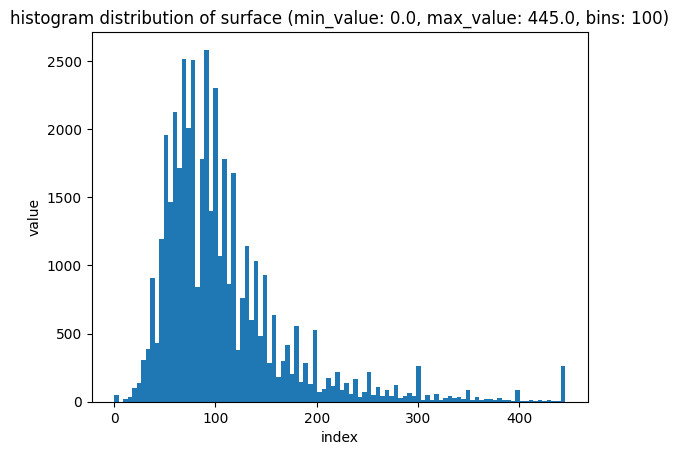

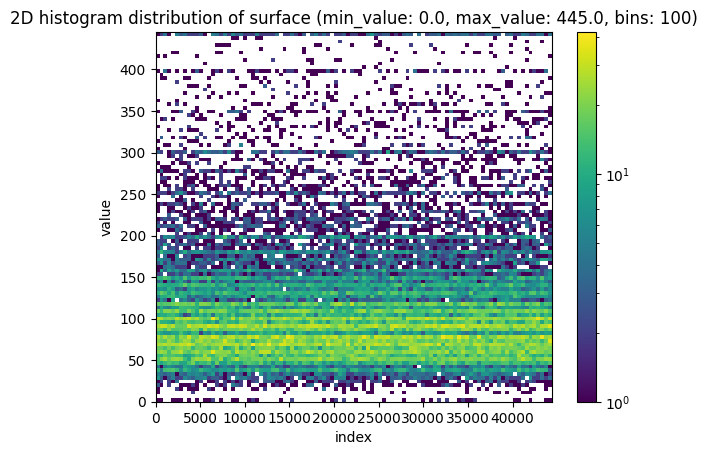

In [33]:
for col in train_df.columns:
    get_hist(train_df, col)

In [34]:
train_df

price  balcony  conditions  construction_year   latitude  longitude   
0       60000.0      1.0         0.0             1980.0  41.901300  12.700000  \
1      900000.0      0.0         0.0             1909.0  41.907017  12.481311   
2       33000.0      0.0         0.0             1960.0  41.976500  12.440500   
3      166000.0      0.0         1.0             1982.4  45.484800  12.198200   
4      410000.0      1.0         0.0             1966.2  45.424480  12.328622   
...         ...      ...         ...                ...        ...        ...   
46307  329999.0      1.0         0.0             1929.0  41.923500  12.446100   
46308  599000.0      1.0         2.0             1920.0  41.916743  12.454925   
46309  549000.0      1.0         0.0             1975.2  45.454701   9.242711   
46310  189000.0      1.0         0.0             1965.0  45.445605   9.245942   
46311  355000.0      1.0         1.0             1970.0  41.877000  12.431400   

       energy_efficiency  expenses  floor  garden  n_bathrooms  elevator   
0                175.000      30.0    2.0     0.0          1.0       1.0  \
1                156.730     112.2    3.0     0.0          1.0       1.0   
2                204.200      30.0    4.0     0.0          1.0       0.8   
3                175.000      34.6    1.0     1.0          1.0       1.0   
4                 65.910      84.2    3.0     0.0          2.0       1.0   
...                  ...       ...    ...     ...          ...       ...   
46307            175.000      35.0    3.0     0.0          1.0       0.8   
46308            157.162     170.0    6.0     0.0          2.0       1.0   
46309            141.502     158.4    5.2     0.0          2.0       1.0   
46310            177.600     150.0   -1.0     1.0          1.0       1.0   
46311            175.000     100.0    1.0     0.0          1.0       1.0   

       total_floors  n_rooms  proximity_to_center  surface  
0               3.0      1.0              1.00000     35.0  
1               4.8      3.0              1.00000    131.0  
2               4.0      1.0              1.00000     16.0  
3               1.0      2.0              0.99205    100.0  
4               5.2      3.0              1.00000     90.0  
...             ...      ...                  ...      ...  
46307           4.0      3.0              1.00000     88.0  
46308           4.6      5.0              1.00000    189.0  
46309           6.6      3.0              1.00000    140.0  
46310           4.8      3.0              1.00000     70.0  
46311           5.0      4.0              1.00000    101.0  

[44460 rows x 16 columns]

# 3. Add Features

In [ ]:
analysis1, analysis2 = NaN_analysis(poi_df)

In [ ]:
analysis1

In [ ]:
analysis2

In [ ]:
poi_df = poi_df[['lat', 'lon']]

In [ ]:
def get_score(poi_df, lat, lon, n_poi):
    tmp_array = sorted(poi_df.to_numpy(), key=lambda x: (x[0]-lat)**2 + (x[1]-lon)**2)[:n_poi]
    tot = 0
    for i in tmp_array:
        tot += (i[0]-lat)**2 + (i[1]-lon)**2
    score = tot/n_poi
    return score

In [ ]:
train_df['poi_score'] = train_df.apply(lambda x: get_score(poi_df, x['latitude'], x['longitude'], 10), axis=1)

In [ ]:
get_hist(train_df, 'poi_score')

# 4. Feature importance analysis

- droppiamo le eventuali features che sono poco importanti per l'apprendimento 

In [42]:
# create x, y
x = train_df.drop('price', axis=1)
y = train_df['price']

In [44]:
from sklearn.ensemble import RandomForestRegressor

# compute feature_importances
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(x, y)
rf.feature_importances_

array([2.93301728e-03, 8.26310192e-03, 1.04560443e-01, 5.16199128e-02,
       6.79416972e-02, 1.43655362e-02, 1.96153053e-01, 1.41528776e-02,
       3.08097210e-03, 3.57868624e-02, 6.40620790e-03, 1.83321095e-02,
       8.33109350e-03, 3.84743973e-04, 4.67688372e-01])

<BarContainer object of 15 artists>

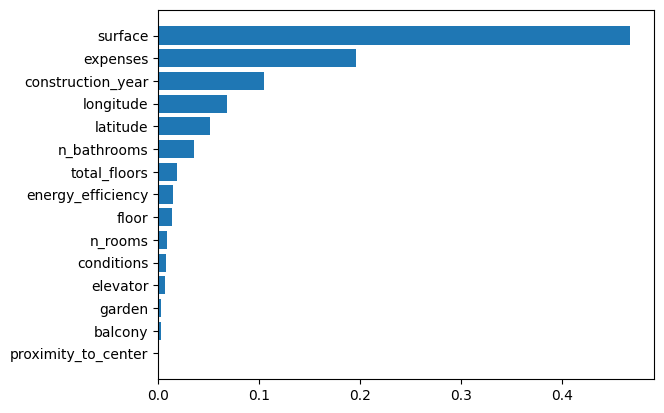

In [45]:
# plot feature_importances
sorted_idx = rf.feature_importances_.argsort()
plt.barh(x.columns[sorted_idx], rf.feature_importances_[sorted_idx])

# 5. Add Samples (Oversampling)

- nel caso di regression non serve undersampling
- quindi facciamo oversampling aumentando i samples sinteticamente con funzioni apposite (SMOTE)
- oppure tramite integrazione di nuovi samples non sintetici da internet

# 5. Training

- creare tutti i regressor possibili e trainarli

In [38]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'RandomForestRegressor': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'MLPRegressor': MLPRegressor()
}

In [56]:
x = train_df.drop('price', axis=1)
y = train_df['price']

MAE: -149584.550 (2075.599)


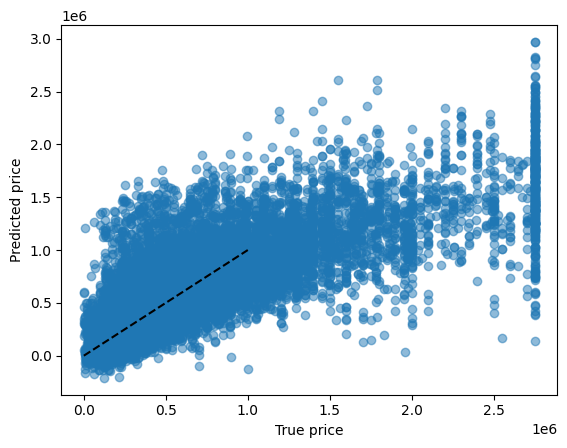

MAE: -149533.017 (2066.132)


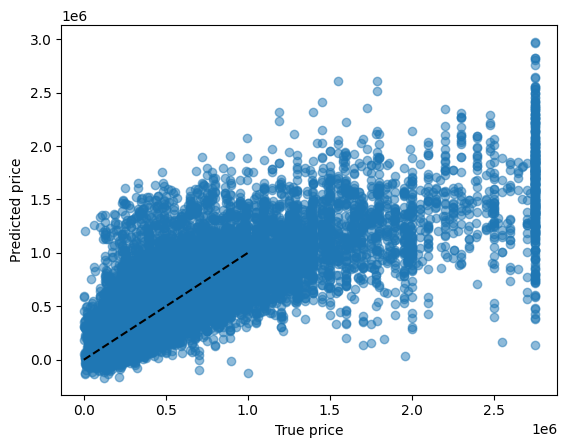

MAE: -149581.788 (2075.189)


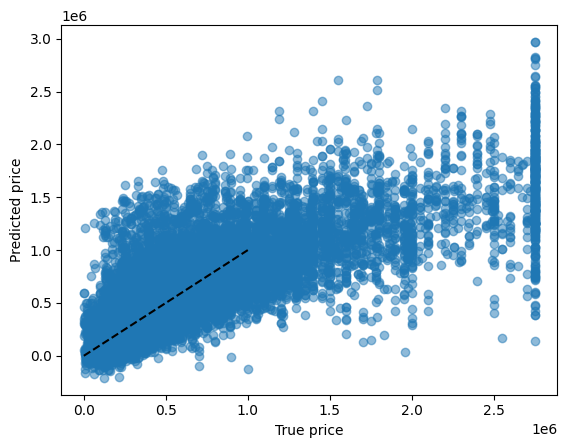

MAE: -148772.926 (1798.959)


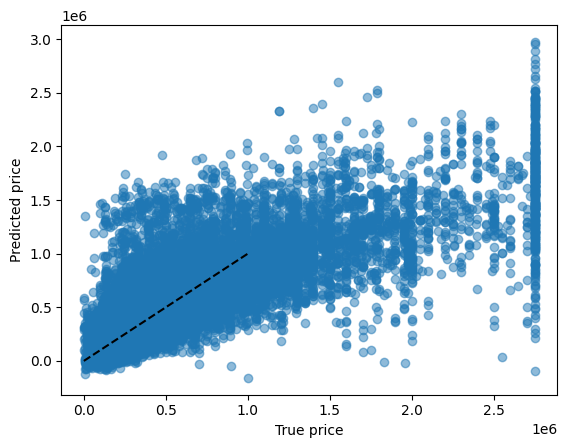

MAE: -81694.215 (849.593)


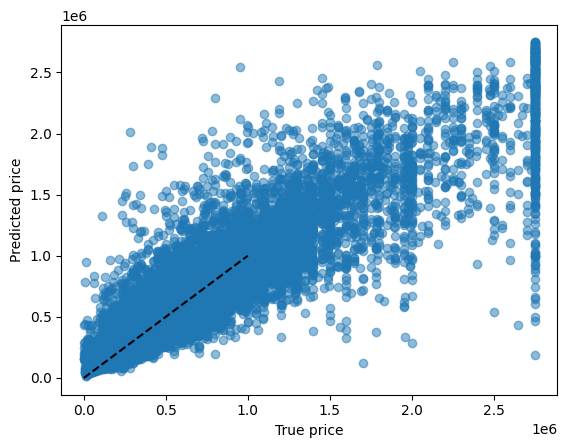

MAE: -104128.205 (1523.768)


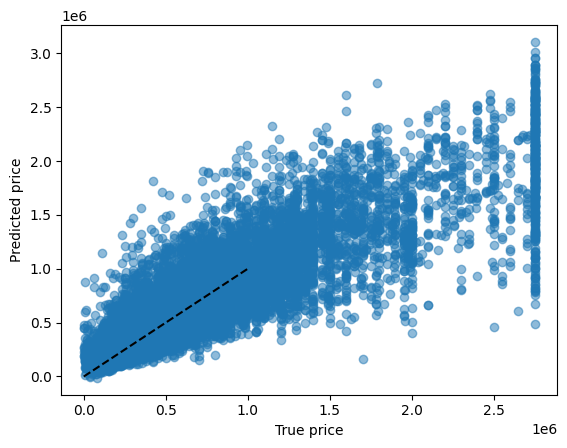

MAE: -235718.440 (1922.833)


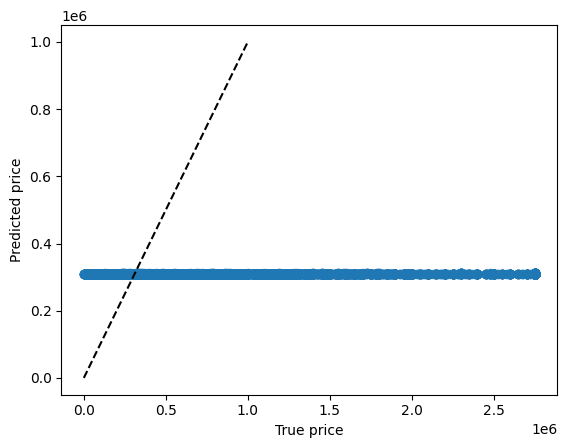

MAE: -130833.724 (1312.354)


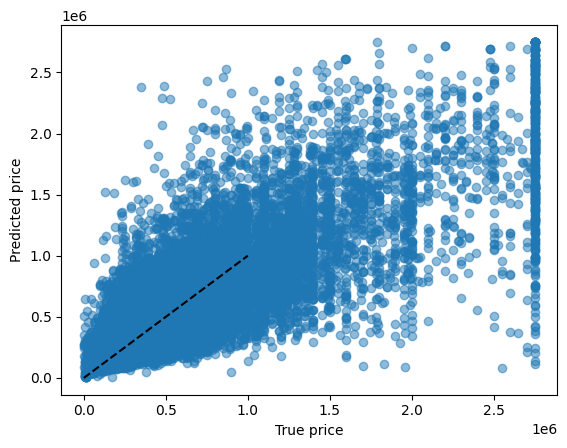

MAE: -112240.874 (1354.919)


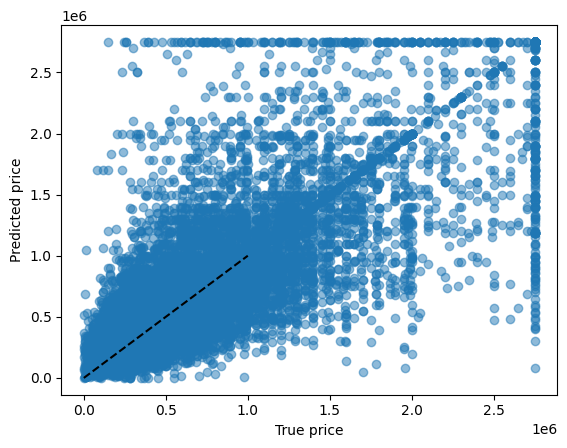

/home/vincenzo/.anaconda3/envs/stable/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/vincenzo/.anaconda3/envs/stable/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/vincenzo/.anaconda3/envs/stable/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/vincenzo/.anaconda3/envs/stable/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

MAE: -155436.885 (1359.128)


/home/vincenzo/.anaconda3/envs/stable/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/vincenzo/.anaconda3/envs/stable/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/vincenzo/.anaconda3/envs/stable/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/vincenzo/.anaconda3/envs/stable/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

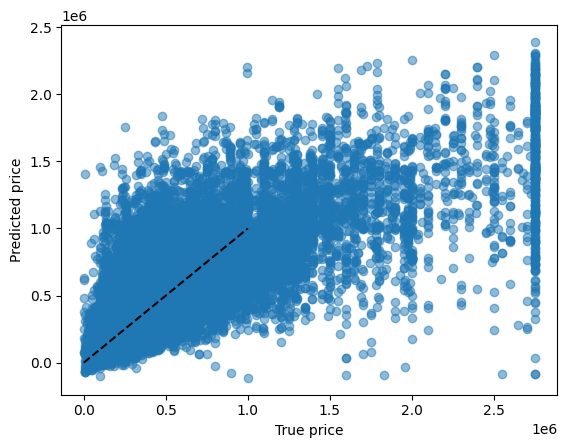

In [53]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
for model_name, model in models.items():
    print('model: {}'.format(model_name))
    model.fit(x, y)

# 6. Testing (evaluation)
- performiamo i modelli trainati sul test set e quindi misuriamo le performance (MSE)

In [59]:
def test_df_preprocessing(test_df, map_conditions, imputer):
    test_df['garden'] = test_df['garden'].fillna(False)
    test_df['balcony'] = test_df['balcony'].fillna(False)
    test_df['garden'] = test_df['garden'].apply(lambda x: 1 if x == True else 0)
    test_df['balcony'] = test_df['balcony'].apply(lambda x: 1 if x == True else 0)
    test_df['conditions'] = test_df['conditions'].apply(lambda x: map_conditions[x])
    test_df['conditions'] = test_df['conditions'].apply(lambda x: np.nan if x == map_conditions[np.nan] else x)
    test_df = pd.DataFrame(imputer.fit_transform(test_df), columns=test_df.columns)
    return test_df

In [ ]:
test_df = test_df_preprocessing(test_df, map_conditions, imputer)

In [65]:
test_df['price'] = models['RandomForestRegressor'].predict(test_df.drop('id', axis=1))

In [70]:
submission_df = test_df[['id', 'price']]
submission_df['id'] = submission_df['id'].astype(int)
submission_df.to_csv('data/submission.csv', index=False)

/tmp/ipykernel_37914/2554578870.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission_df['id'] = submission_df['id'].astype(int)


In [ ]:
# evaluate the model 
scores = cross_val_score(model, x, y, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
print('MAE: {:.3f} ({:.3f})'.format(scores.mean(), scores.std()))
y_pred = cross_val_predict(model, x, y, cv=5, n_jobs=-1)
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([0, 1000000], [0, 1000000], '--k')
plt.xlabel('True price')
plt.ylabel('Predicted price')
plt.show()
plt.close()

/home/vincenzo/.anaconda3/envs/stable/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/vincenzo/.anaconda3/envs/stable/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/vincenzo/.anaconda3/envs/stable/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/vincenzo/.anaconda3/envs/stable/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

MSE: -66929083874.669 (2581057410.656)


/home/vincenzo/.anaconda3/envs/stable/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/vincenzo/.anaconda3/envs/stable/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/vincenzo/.anaconda3/envs/stable/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/vincenzo/.anaconda3/envs/stable/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

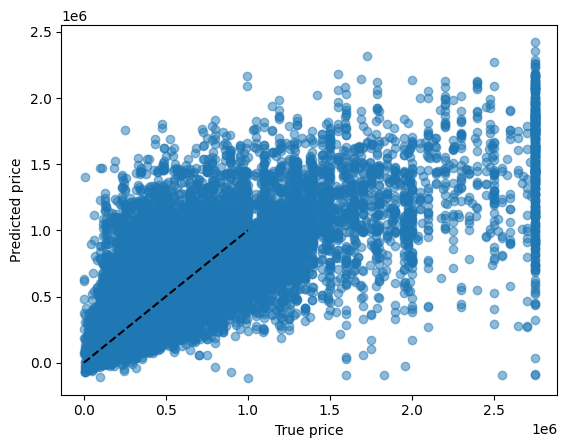

In [71]:
# evaluate the model MSE
scores = cross_val_score(model, x, y, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
print('MSE: {:.3f} ({:.3f})'.format(scores.mean(), scores.std()))
y_pred = cross_val_predict(model, x, y, cv=5, n_jobs=-1)
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([0, 1000000], [0, 1000000], '--k')
plt.xlabel('True price')
plt.ylabel('Predicted price')
plt.show()
plt.close()


# 7. Tuning

- troviamo la combinazione di iperparametri migliori per il modello migliore che abbiamo fino ad ora ottenuto
- quindi accordiamo il modello migliore